In [153]:
import librosa
import numpy as np
import random
import rosbag
import struct
import tams_pr2_guzheng
from collections import Counter

from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-v0_8')
import matplotlib.animation as animation
from IPython import display


In [2]:
# enable publisher for audio
import rospy
rospy.init_node('jupyter_lab')

In [3]:
%load_ext autoreload
%autoreload 1
import sys
if '../utils' not in sys.path:
    sys.path.append('../utils')
import u
%aimport u

In [4]:
bag_name = '/home/v4hn/ros/one/guzheng/bags/ransac_b4/guzheng_ransac_b4_2023-07-03-15-25-20_extracted_episodes.bag'

In [6]:
bag_name = 'guzheng_reworked-aggregation-test_2023-06-01-13-29-38_extracted_episodes.bag'

In [8]:
bag_name = 'guzheng_reworked-aggregation-test-a4_2023-06-01-15-33-30_extracted_episodes.bag'

In [6]:
bag_name = 'guzheng_150_fis4_random_ypos_2023-06-15-18-57-36_extracted_episodes.bag'

In [7]:
bag_name = 'guzheng_150_fis4_random_ypos_dir-1.0_2023-06-15-19-18-40_extracted_episodes.bag'

In [8]:

#bag_name = 'guzheng_4_positions_a4_2023-02-28-19-09-35_extracted_episodes.bag'
#bag_name = 'guzheng_a-strings-a4_2023-02-28-13-44-48_extracted_episodes.bag'
#bag_name = 'guzheng_a-strings-a5_2023-02-28-15-11-51_extracted_episodes.bag'
#bag_name = 'guzheng_b3-compare-string-positions_2023-02-23-15-52-27_extracted_episodes.bag'
#bag_name = 'guzheng_b3-compare-string-positions-2_2023-02-23-18-39-59_extracted_episodes.bag'
#bag_name = 'guzheng_a-strings-2_2023-02-21-20-00-29_extracted_episodes.bag'
#bag_name = 'guzheng_a-strings_2023-02-20-13-16-10_extracted_episodes.bag'
#bag_name = 'guzheng_b3-ransac-string-calibrated-tip_2023-02-22-15-29-00_extracted_episodes.bag'

In [5]:
if bag_name[0] != '/':
    bag_path = "../../../../bags/" + bag_name
else:
    bag_path = bag_name
    bag_name = bag_name.split('/')[-1]

bag = rosbag.Bag(bag_path)

episodes_full_bag = [m for t,m,_ in bag.read_messages()]

In [6]:
# assume unique IDs (overwhelmingly likely, but if wrong we might want to know)
assert len({e.id for e in episodes_full_bag}) == len(episodes_full_bag)

In [7]:
target_strings= Counter([e.string for e in episodes_full_bag])
detected_notes = Counter([o.note for e in episodes_full_bag for o in e.detected_audio_onsets])
fingers= Counter(e.finger for e in episodes_full_bag)
# detected_notes= {o.note for e in episodes_full_bag for o in e.detected_audio_onsets}
start_time= episodes_full_bag[0].header.stamp

print(f"Summary\n-------\n")

print(f"experiment ran for {int((episodes_full_bag[-1].header.stamp - episodes_full_bag[0].header.stamp).to_sec()/60)} minutes")
print("used fingers: "+', '.join([f"{f}({fingers[f]})" for f in fingers]))

print("targeted strings in bag: "+', '.join([f"{s}({target_strings[s]})" for s in target_strings]))

empty_string= "''"
print("detected notes in bag: " + ', '.join([ f"{n}({detected_notes[n]})" if len(n) > 0 else empty_string for n in detected_notes]) +"\n")

note = list(target_strings)[0]
#note = 'a4'

note_bucket = u.cqt_range.index(note)
print(f'target note for analysis is {note}')
print(f'target bucket in cqt is {note_bucket}')

Summary
-------

experiment ran for 6 minutes
used fingers: ff(60)
targeted strings in bag: b4(60)
detected notes in bag: D♯4(1), B4(67), A4(1)

target note for analysis is b4
target bucket in cqt is 35


In [8]:
# limit analysis to a single string
episodes_all = [e for e in episodes_full_bag if e.string == note]

# drop invalid samples
episodes_valid= [e for e in episodes_all if
                 (len(e.detected_audio_onsets) == 0
                 or len(e.detected_audio_onsets) > 0
                 and e.start_execution < e.detected_audio_onsets[0].header.stamp
                 and e.string in [u.note_to_string(o.note) for o in e.detected_audio_onsets])
                 and len(e.executed_path.poses) > 0]
episodes = episodes_valid
episodes_with_onset = [e for e in episodes if len(e.detected_audio_onsets) > 0]
episodes_with_one_onset = [e for e in episodes if len(e.detected_audio_onsets) == 1]
episodes_with_no_onset = [e for e in episodes if len(e.detected_audio_onsets) == 0]
episodes_with_two_onsets = [e for e in episodes if len(e.detected_audio_onsets) == 2]
episodes_with_many_onsets = [e for e in episodes if len(e.detected_audio_onsets) > 2]
episodes_forward = [e for e in episodes if e.commanded_path.poses[0].pose.position.y > 0.0]
episodes_backward = [e for e in episodes if e.commanded_path.poses[0].pose.position.y < 0.0]

episodes_with_one_onset_forward = [e for e in episodes_with_one_onset if e.commanded_path.poses[0].pose.position.y > 0.0]
episodes_with_one_onset_backward = [e for e in episodes_with_one_onset if e.commanded_path.poses[0].pose.position.y < 0.0]
episodes_with_no_onset_forward = [e for e in episodes_with_no_onset if e.commanded_path.poses[0].pose.position.y > 0.0]
episodes_with_no_onset_backward = [e for e in episodes_with_no_onset if e.commanded_path.poses[0].pose.position.y < 0.0]

In [9]:
plt.title('Unfiltered list of detected onsets')
agg = Counter([o.note for e in episodes_valid for o in e.detected_audio_onsets])
bars= plt.barh(np.arange(len(agg.keys())), agg.values(), tick_label=list(agg.keys()));
plt.bar_label(bars, padding=5);
u.save_plot(f'onesets {bag_name}')

/home/v4hn/ros/one/guzheng/src/tams_pr2_guzheng/notebooks/Episodes/../utils/u.py:47: UserWarning: Glyph 9839 (\N{MUSIC SHARP SIGN}) missing from current font.
  plt.savefig(f'plots/{s}.png', dpi= 150)
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9839 (\N{MUSIC SHARP SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


In [10]:
plt.title("episode types")
bars= plt.barh(
    np.arange(7),
    [len(episodes), len(episodes_with_one_onset), len(episodes_all)-len(episodes_valid), len(episodes_with_no_onset), len(episodes)-len(episodes_with_no_onset), len(episodes_with_one_onset_forward), len(episodes_with_one_onset_backward)],
    tick_label= ["total", "one onset", "invalid", "no onset", "onset(s)", "one onset forward", "one onset backward"]
    );
plt.bar_label(bars, padding=5);
u.save_plot(f'episodes {bag_name}')

In [11]:
plt.title('number of audio onsets per episode')
onset_cnts = Counter([len(e.detected_audio_onsets) for e in episodes])
bars= plt.bar(*list(zip(*sorted(onset_cnts.items()))))
plt.xticks(list(onset_cnts.keys()))
plt.bar_label(bars, padding=5);
u.save_plot(f'onsets {bag_name}')

In [12]:
plt.title('episode length hist')
_,_,bars= plt.hist([e.header.stamp.to_sec() + e.length.to_sec() - e.start_execution.to_sec() for e in episodes]);
plt.bar_label(bars, padding=5);
plt.xlabel('time (s)')
u.save_plot(f'episode length {bag_name}')

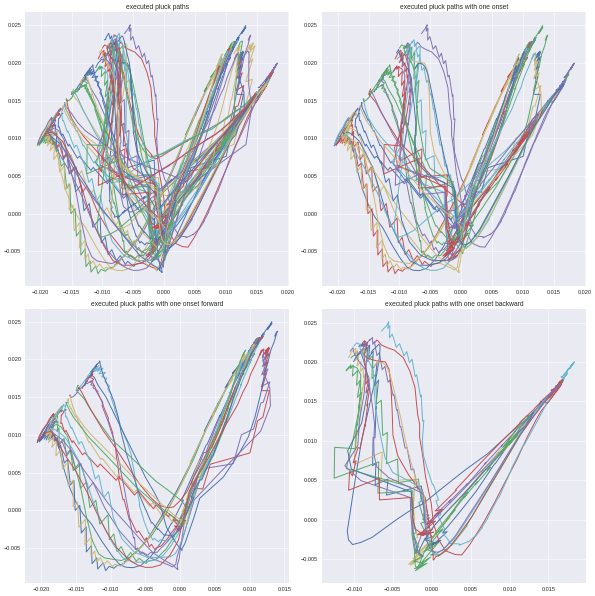

In [13]:
plt.figure(figsize=(15,15), dpi=40)
plt.subplot(2,2,1)
plt.title('executed pluck paths')
for e in episodes:
    plt.plot(*u.tip_path(e.executed_path))
plt.subplot(2,2,2)
plt.title('executed pluck paths with one onset')
for e in episodes_with_one_onset:
    plt.plot(*u.tip_path(e.executed_path))
plt.subplot(2,2,3)
plt.title('executed pluck paths with one onset forward')
for e in episodes_with_one_onset_forward:
    plt.plot(*u.tip_path(e.executed_path))
plt.subplot(2,2,4)
plt.title('executed pluck paths with one onset backward')
for e in episodes_with_one_onset_backward:
    plt.plot(*u.tip_path(e.executed_path))

plt.tight_layout()
u.save_plot(f'paths {bag_name}')

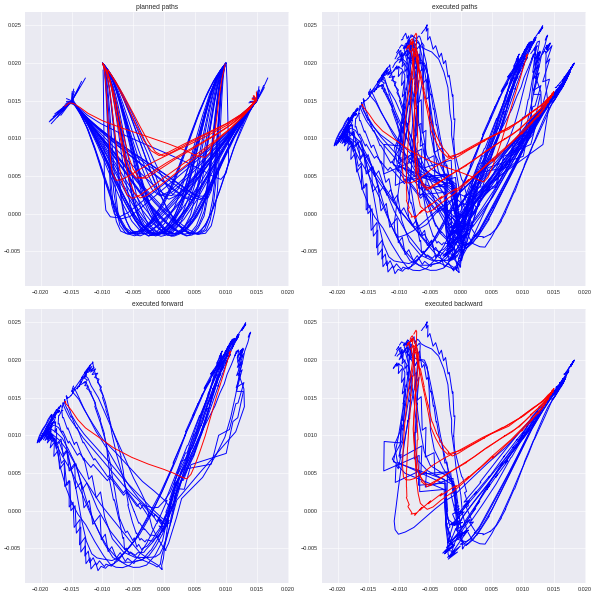

In [14]:
plt.figure(figsize=(15,15), dpi=40)

plt.subplot(2, 2, 1)
plt.title('planned paths')
for e in episodes_with_onset:
    plt.plot(*u.tip_path(e.planned_path), color='b')
for e in episodes_with_no_onset:
    plt.plot(*u.tip_path(e.planned_path), color='r')    

plt.subplot(2, 2, 2, sharey= plt.gca(), sharex= plt.gca())
plt.title('executed paths')
for e in episodes_with_onset:
    plt.plot(*u.tip_path(e.executed_path), color='b')
for e in episodes_with_no_onset:
    plt.plot(*u.tip_path(e.executed_path), color='r')

plt.subplot(2, 2, 3, sharey= plt.gca(), sharex= plt.gca())
plt.title('executed forward')
for e in episodes_with_one_onset_forward:
    plt.plot(*u.tip_path(e.executed_path), color='b')
for e in episodes_with_no_onset_forward:
    plt.plot(*u.tip_path(e.executed_path), color='r')

plt.subplot(2, 2, 4, sharey= plt.gca(), sharex= plt.gca())
plt.title('executed backward')
for e in episodes_with_one_onset_backward:
    plt.plot(*u.tip_path(e.executed_path), color='b')
for e in episodes_with_no_onset_backward:
    plt.plot(*u.tip_path(e.executed_path), color='r')

plt.tight_layout()
u.save_plot(f'episodes {bag_name}')

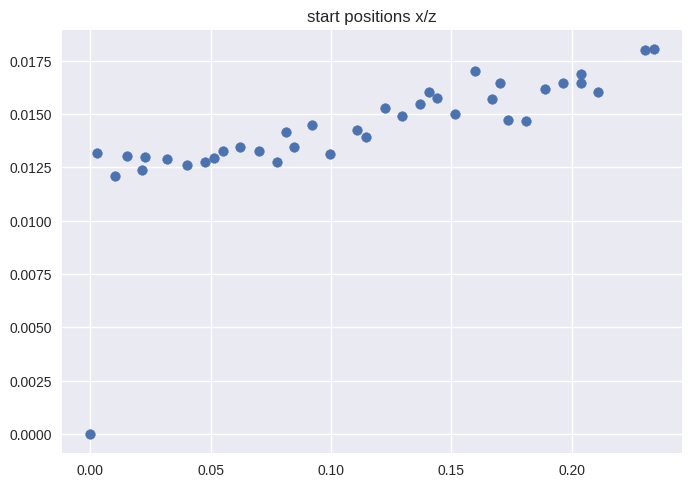

In [15]:
plt.title('start positions x/z')
plt.scatter(*list(zip(*[(e.finger_start_pose.pose.position.x, e.finger_start_pose.pose.position.z) for e in episodes_with_one_onset]+[(0.0,0.0)])))

u.save_plot(f'positions along string {bag_name}')

In [156]:
es= sorted(episodes,key= lambda e: e.action_parameters.action_parameters[14])

fig, ax = plt.subplots()

LINES= 10
lines=[]
for x in range(LINES):
    lines.append( ax.plot([], c='b')[0] )

ax.set_xlim(-0.02, 0.02)
ax.set_ylim(-0.01, 0.025)
ax.set_aspect('equal', 'box')
ax.set_title('executed forward')

def animate(i):
    lines[i%LINES].set_data(u.tip_path(es[i].executed_path))
    lines[i%LINES].set_color('red' if len(es[i].detected_audio_onsets) == 0 else 'blue')
    ax.set_title(f"d = {es[i].action_parameters.action_parameters[14]:.3f}")
    return lines

anim = animation.FuncAnimation(
    fig,
    animate,
    frames=len(es), interval=100)
u.show_animation(anim)
u.save_anim(anim, f'plucks along string {bag_name}')

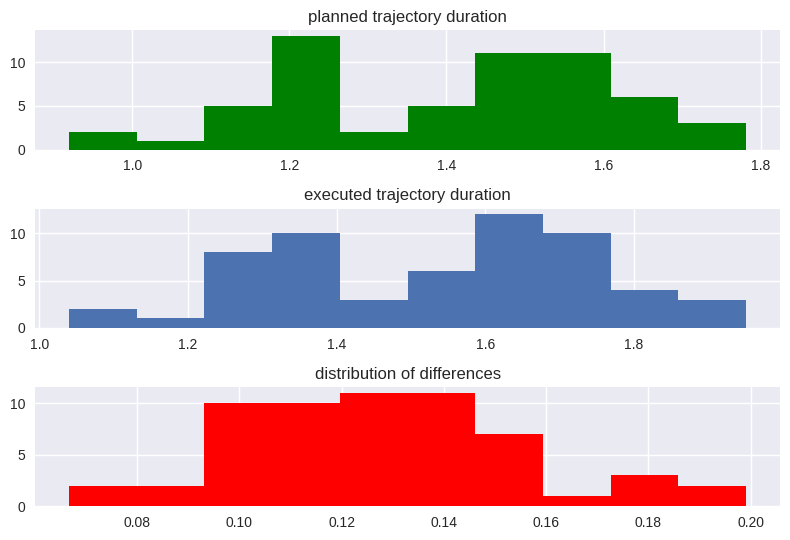

In [17]:
plt.subplot(3,1,1)
plt.title('planned trajectory duration')
plt.hist([(e.planned_trajectory.points[-1].time_from_start).to_sec() for e in episodes], color='g');
plt.subplot(3,1,2)
plt.title('executed trajectory duration')
plt.hist([(e.executed_trajectory.points[-1].time_from_start).to_sec() for e in episodes]);
plt.subplot(3,1,3)
plt.title('distribution of differences')
plt.hist([(e.executed_trajectory.points[-1].time_from_start - e.planned_trajectory.points[-1].time_from_start).to_sec() for e in episodes], color= 'red');
plt.tight_layout()
u.save_plot(f'actuation length {bag_name}')

In [18]:
plt.title('onsets from actuation')
onsets = []

for e in episodes:
    for o in e.detected_audio_onsets:
        onsets.append((e.start_execution.to_sec()-start_time.to_sec(), (o.header.stamp - e.start_execution).to_sec()))

t,v = list(zip(*onsets))
plt.scatter(t,v);
averaging_window= 11
plt.plot(t[int(averaging_window/2):-int(averaging_window/2)], np.convolve(v, np.ones(averaging_window)/averaging_window, mode='valid'), 'r')

plt.xlabel('time from start of experiment [s]')
plt.ylabel('onset time from start of actuation [s]')

u.save_plot(f'onsets from actuation {bag_name}')

In [20]:
plt.title('plucks from actuation')
plucks_all = []
for i, e in enumerate(episodes):
    plucks = [((p.header.stamp-start_time).to_sec(), (p.header.stamp - e.start_execution).to_sec()) for p in e.detected_tactile_plucks]
    if len(plucks) > 0:
        plt.scatter(*list(zip(*plucks)))
    plucks_all+= plucks

t,v = list(zip(*plucks_all))
averaging_window= 11
plt.plot(t[int(averaging_window/2):-int(averaging_window/2)], np.convolve(v, np.ones(averaging_window)/averaging_window, mode='valid'), 'r')
plt.xlabel('time from start of experiment [s]')
plt.ylabel('tactile pluck time from start of actuation [s]')

u.save_plot(f'plucks from actuation {bag_name}')

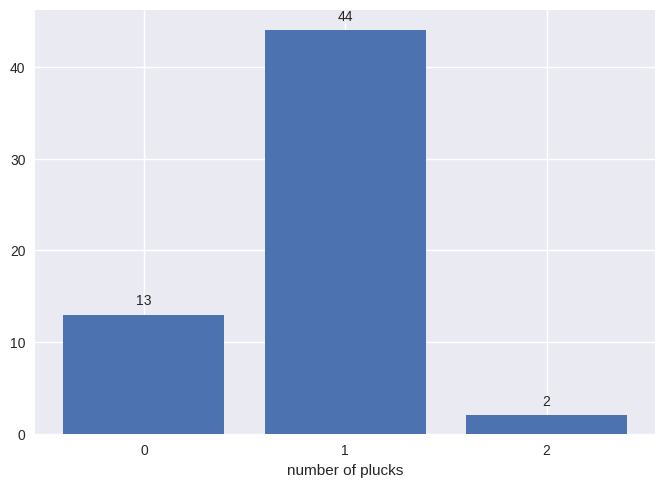

In [21]:
plucks_cnt = Counter(len(e.detected_tactile_plucks) for e in episodes)
bars= plt.bar(*list(zip(*plucks_cnt.items())));
plt.gca().set_xticks(range(len(plucks_cnt)))
plt.xlabel('number of plucks')

plt.bar_label(bars, padding=5);

u.save_plot(f'plucks {bag_name}')

In [22]:
audio_tactile_delay_time= np.array([(e.detected_audio_onsets[0].header.stamp - episodes_with_one_onset[0].header.stamp).to_sec() for e in episodes_with_one_onset if len(e.detected_tactile_plucks) > 0])
audio_tactile_delay=np.array([(e.detected_audio_onsets[0].header.stamp - e.detected_tactile_plucks[0].header.stamp).to_sec() for e in episodes_with_one_onset if len(e.detected_tactile_plucks) > 0])
audio_tactile_delay_idx=[i for i,e in enumerate(episodes_with_one_onset) if len(e.detected_tactile_plucks) > 0]

# plt.plot(audio_tactile_delay_time[audio_tactile_delay > -0.4], audio_tactile_delay[audio_tactile_delay > -0.4], 'o')
plt.plot(audio_tactile_delay_time, audio_tactile_delay, 'o')
averaging_window= 11
plt.plot(audio_tactile_delay_time[int(averaging_window/2):-int(averaging_window/2)], np.convolve(audio_tactile_delay, np.ones(averaging_window)/averaging_window, mode='valid'), 'r')
plt.title("delay between audio onsets and pluck detections");
plt.xlabel('time from start of experiment (s)')
plt.ylabel('delay (s)')

u.save_plot(f'onsets plucks delay {bag_name}')

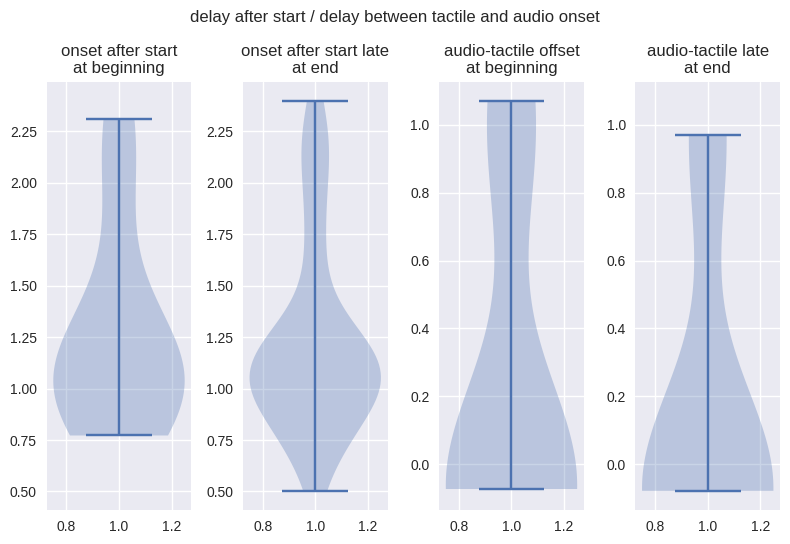

In [31]:
t_early = (episodes_with_onset[-1].start_execution + episodes_with_one_onset[-1].length - start_time).to_sec() / 5
t_late = len(episodes_with_onset)-t_early
i_early = len(episodes_with_onset) / 5
i_late = len(episodes_with_onset) - i_early

onsets_early = [o for t, o in onsets if t < t_early]
onsets_late = [o for t, o in onsets if t > t_late]
plt.suptitle('delay after start / delay between tactile and audio onset')
plt.subplot(1,4,1)
ax = plt.gca()
plt.title('onset after start\nat beginning')
if len(onsets_early) > 0:
    plt.violinplot(onsets_early);
plt.subplot(1,4,2, sharey= ax)
plt.title('onset after start late\nat end')
plt.violinplot(onsets_late);

plt.subplot(1,4,3)
ax = plt.gca()
plt.title('audio-tactile offset\nat beginning')
plt.violinplot([(e.detected_audio_onsets[-1].header.stamp-e.detected_tactile_plucks[-1].header.stamp).to_sec() for i, e in enumerate(episodes_with_onset) if len(e.detected_tactile_plucks) ==1 and i < i_early]);
plt.subplot(1,4,4, sharey= ax)
plt.title('audio-tactile late\nat end')
plt.violinplot([(e.detected_audio_onsets[-1].header.stamp-e.detected_tactile_plucks[-1].header.stamp).to_sec() for i, e in enumerate(episodes_with_onset) if len(e.detected_tactile_plucks) ==1 and i > i_late]);
plt.tight_layout()
u.save_plot(f'delays early-late {bag_name}')

In [25]:
%%html
<!-- allegedly works in jupyer lab -->
<style>
    .jp-OutputArea-child {
        display: inline-block;
    }
</style>

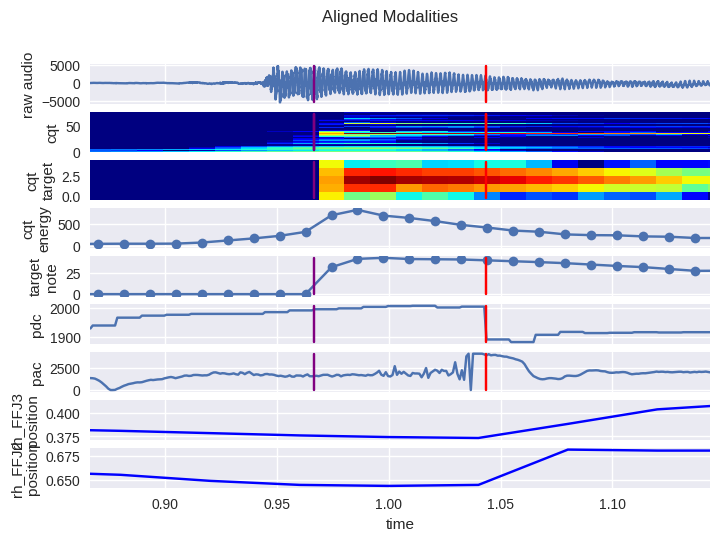

In [32]:
e = episodes_with_one_onset[-1]
u.plot_aligned_audio_tactile(e, context=.1)

(0.6, 1.2)

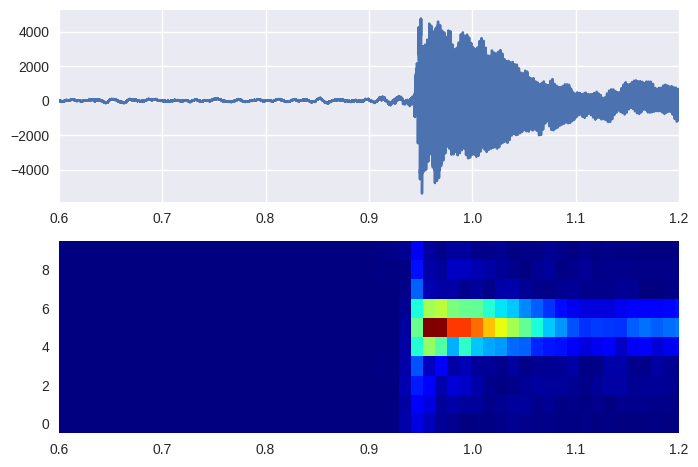

In [33]:
audio = u.audio_from_episode(e)
data_start = (e.audio_data.header.stamp-e.start_execution).to_sec()
ax= plt.subplot(2,1,1)
plt.plot(data_start + np.arange(audio.size)/e.audio_info.sample_rate, audio)

cqt_idx= u.target_cqt_idx(e)
cqt = np.abs(
    librosa.cqt(
        y=audio,
        sr=e.audio_info.sample_rate,
        hop_length=e.cqt.hop_length,
        fmin=librosa.note_to_hz('C2'),
        n_bins=74,
    )
)[cqt_idx-5:cqt_idx+5]
data_start = (e.audio_data.header.stamp-e.start_execution).to_sec()
X= np.tile((data_start + np.arange(cqt.shape[1])*e.cqt.hop_length/e.cqt.sample_rate)[:, np.newaxis], cqt.shape[0]).T
Y= np.tile(np.arange(cqt.shape[0])[:,np.newaxis], cqt.shape[1])
plt.subplot(2,1,2, sharex= ax)
plt.pcolormesh(X, Y, cqt, cmap='jet')
plt.xlim([0.6, 1.2])


In [96]:
", ".join(u.cqt_range)

'c2, cis2, d2, dis2, e2, f2, fis2, g2, gis2, a2, ais2, b2, c3, cis3, d3, dis3, e3, f3, fis3, g3, gis3, a3, ais3, b3, c4, cis4, d4, dis4, e4, f4, fis4, g4, gis4, a4, ais4, b4, c5, cis5, d5, dis5, e5, f5, fis5, g5, gis5, a5, ais5, b5, c6, cis6, d6, dis6, e6, f6, fis6, g6, gis6, a6, ais6, b6, c7, cis7, d7, dis7, e7, f7, fis7, g7, gis7, a7, ais7, b7, c8'

TypeError: unsupported operand type(s) for -: 'Duration' and 'float'

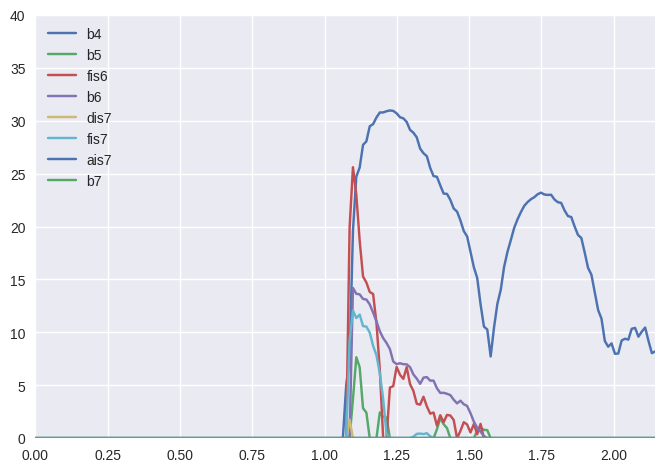

In [170]:
e= episodes_with_one_onset[np.random.randint(len(episodes_with_one_onset))]

plt.figure()
u.plot_harmonics(e)
plt.ylim((0, 40))
plt.xlim(((e.detected_audio_onsets[0].header.stamp-e.start_execution-0.2).to_sec(), e.length.to_sec()))

In [272]:
fundamental_note_idx = u.cqt_range.index(e.string)
# fundamental_note_idx = u.cqt_range.index('b3')
harmonics = [fundamental_note_idx + i for i in (0, 12, 19, 24, 28, 31, 35, 36) if fundamental_note_idx + i < len(u.cqt_range)]
# harmonics = [harmonics[0], harmonics[1]]

es= sorted(episodes_with_one_onset,key= lambda e: e.action_parameters.action_parameters[14])

fig, ax = plt.subplots()

ax_position = fig.add_axes([0, 0.95, 1, 0.05])
ax_position.set_xlim((0, max([e.action_parameters.action_parameters[14] for e in es])))

plts= []
for e in es:
    cqt= u.cqt_from_episode(e).T

    onset_time_from_start = (e.detected_audio_onsets[0].header.stamp-e.cqt.header.stamp).to_sec() - 0.1
    onset_hop = int(onset_time_from_start*e.cqt.sample_rate/e.cqt.hop_length)
    cqt= cqt[harmonics, onset_hop:]
    # klirr = cqt[2] / cqt[0]
    cqt_t= np.arange(cqt.shape[1])*e.cqt.hop_length/e.cqt.sample_rate
    ax.set_prop_cycle(None)
    plots = ax.plot(cqt_t, cqt.T) # or klirr.T
    ax.set_xlim([0, max(cqt_t)])
    ax.legend([u.cqt_range[h] for h in harmonics], loc='upper left')

    pos_plot = ax_position.axvline(e.action_parameters.action_parameters[14], 0, 1, color='k')
    plots.append(pos_plot)

    plts.append(plots)

anim = animation.ArtistAnimation(fig, plts, interval=300, blit=True,
                                repeat_delay=1000)

u.show_animation(anim)

In [273]:
fundamental_note_idx = u.cqt_range.index(e.string)
# fundamental_note_idx = u.cqt_range.index('b3')
harmonics = [fundamental_note_idx + i for i in (0, 12, 19, 24, 28, 31, 35, 36) if fundamental_note_idx + i < len(u.cqt_range)]
harmonics = harmonics[:4]

es= sorted(episodes_with_one_onset,key= lambda e: e.action_parameters.action_parameters[14])

fig, ax = plt.subplots()

ax.set_title('Harmonics along string over time')
ax.set_aspect(0.01)
ax.set_yticks(np.arange(len(harmonics)), labels=[u.cqt_range[h] for h in harmonics])
ax.set_ylim(-0.5, len(harmonics)-0.5)

ax_position = fig.add_axes([0, 0.95, 1, 0.05])

pre_onset_offset = 0.05

cqts= []
for e in es:
    cqt= u.cqt_from_episode(e).T

    onset_time_from_start = (e.detected_audio_onsets[0].header.stamp-e.cqt.header.stamp).to_sec() - pre_onset_offset
    onset_hop = int(onset_time_from_start*e.cqt.sample_rate/e.cqt.hop_length)
    cqt= cqt[harmonics, onset_hop:]
    cqts.append(cqt)

string_positions = np.array([e.action_parameters.action_parameters[14] for e in es])

plts= []
for t in range(0, 30):
    at_time = np.array([cqt[:, t] for cqt in cqts]).ravel()

    plots = []
    cloud = ax.scatter(
        np.repeat(string_positions, len(harmonics)),
        np.tile(np.arange(len(harmonics)), len(string_positions)),
        c=at_time,
        cmap='RdPu', s=100)
    plots.append(cloud)
    pos_plot = ax_position.axvline(t*es[0].cqt.hop_length/es[0].cqt.sample_rate - pre_onset_offset, color='k')
    plots.append(pos_plot)
    plts.append(plots)

anim = animation.ArtistAnimation(fig, plts, interval=300, blit=True,
                                repeat_delay=1000)
u.show_animation(anim)


In [91]:
u.play_audio(e)

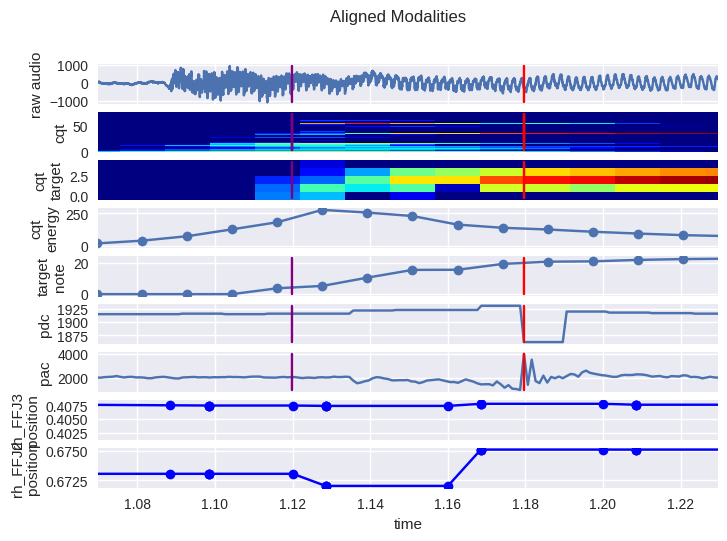

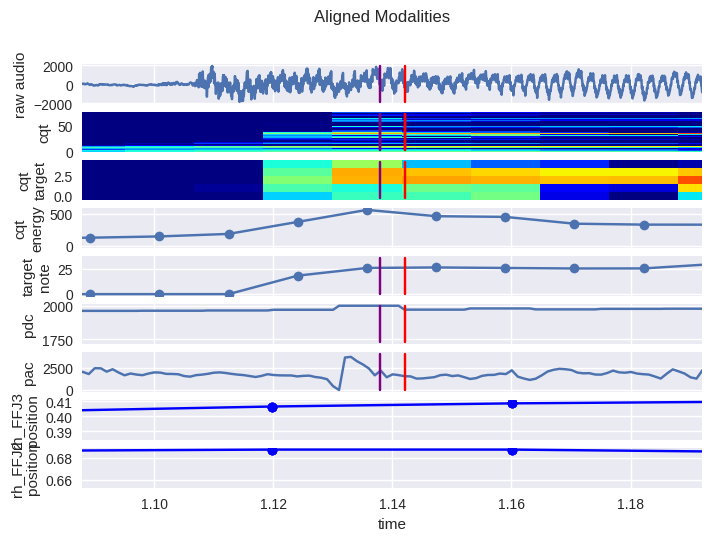

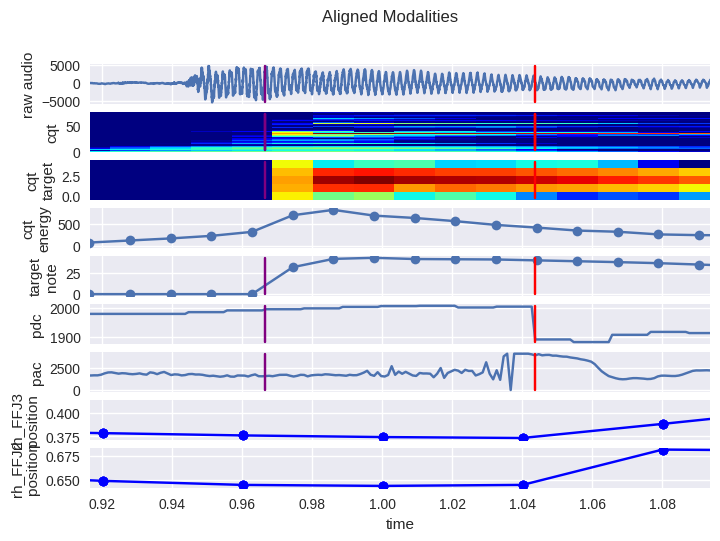

In [85]:
e = episodes_with_one_onset[0]
u.plot_aligned_audio_tactile(e, context=0.05)
plt.figure()
e = episodes_with_one_onset[len(episodes_with_one_onset)//2+1]
u.plot_aligned_audio_tactile(e, context=0.05)
plt.figure()
e = episodes_with_one_onset[-1]
u.plot_aligned_audio_tactile(e, context=0.05)

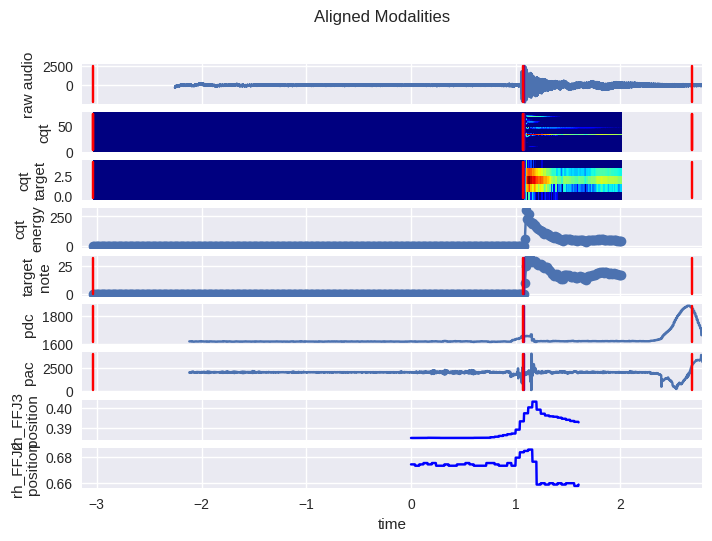

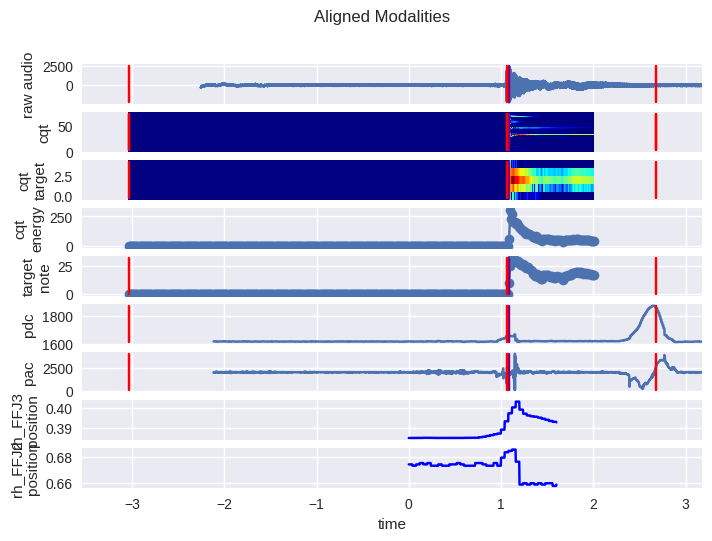

In [29]:
e = episodes_with_one_onset[13]
u.plot_aligned_audio_tactile(e, context=0.1)
plt.figure()
u.plot_aligned_audio_tactile(e, context=0.5)

Episode 1688397982
------------------

start: 1688397984.2684543
length: 2.078945158

executed trajectory sampled at 102.24025785810953

onsets: 1
       - B4 at 0.944562 with 43.30dB
plucks: 1
       - 1.01751 ff with strength 83.00


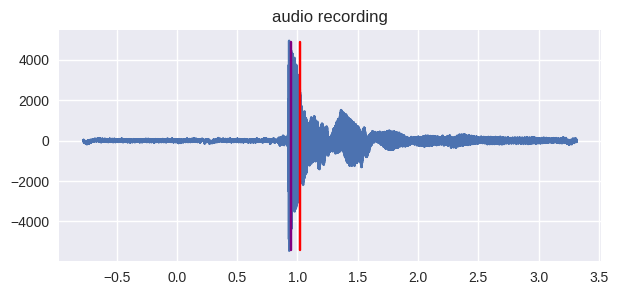

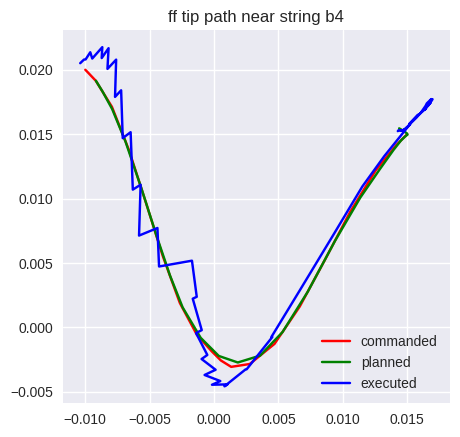

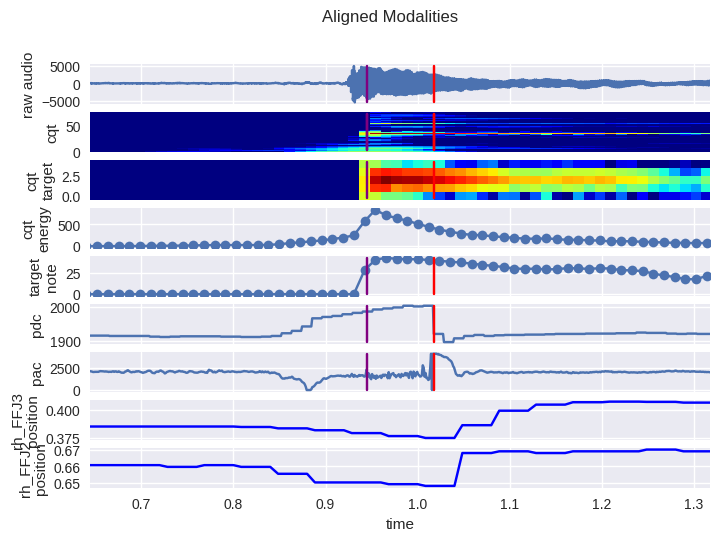

<Figure size 700x1500 with 0 Axes>

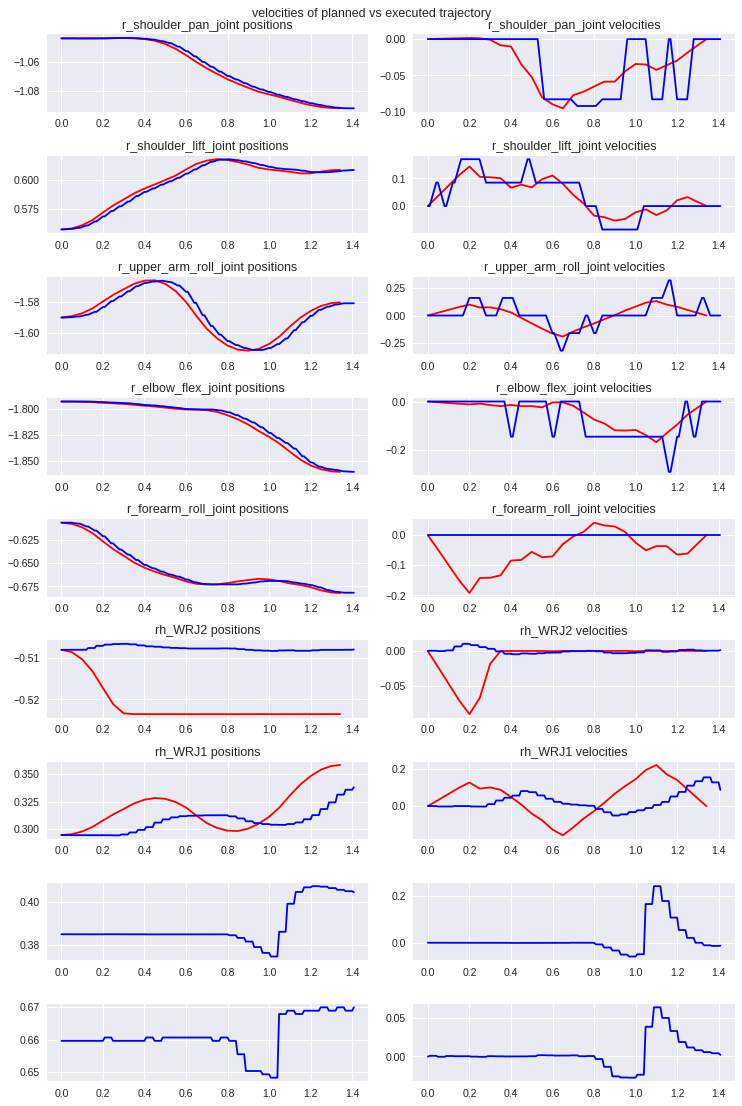

In [39]:
N=5
ei, e = N, episodes_with_one_onset[N]

if N < 0:
    ei, e = random.choice([(i,e) for i,e in enumerate(episodes_with_one_onset)])

u.describe_episode(e)    
u.plot_episode(e);

In [41]:
episodes_with_many_onsets = [e for e in episodes if len(e.detected_audio_onsets) >= 4]

if (nr:= len(episodes_with_many_onsets)) > 0:
    print(f"{nr} episodes with many onsets")
    u.plot_episode(random.choice(episodes_with_many_onsets), joints= False)

In [42]:
onsets= []
for i, e in enumerate(episodes_with_two_onsets):
    for o in e.detected_audio_onsets:
        onsets.append((i, (o.header.stamp - e.start_execution).to_sec()))
if len(onsets) > 0:
    plt.title('2 onset episodes onset after execution')
    plt.scatter(*list(zip(*onsets)))
for i, o in onsets:
    plt.text(i+0.05, o, str(i), fontsize=12)

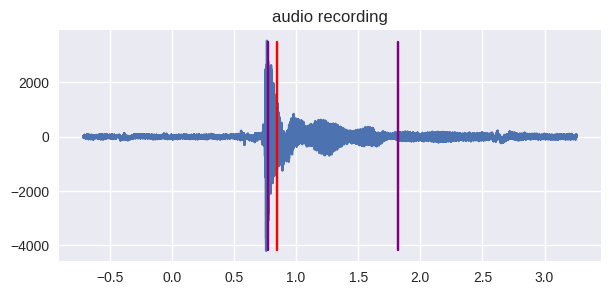

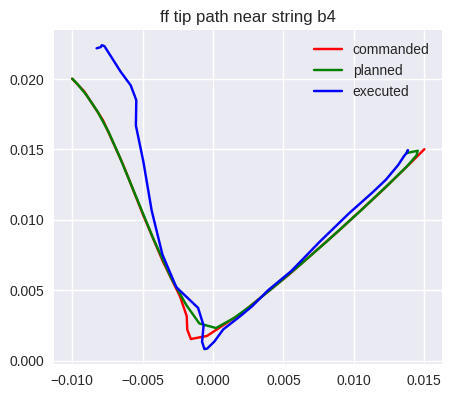

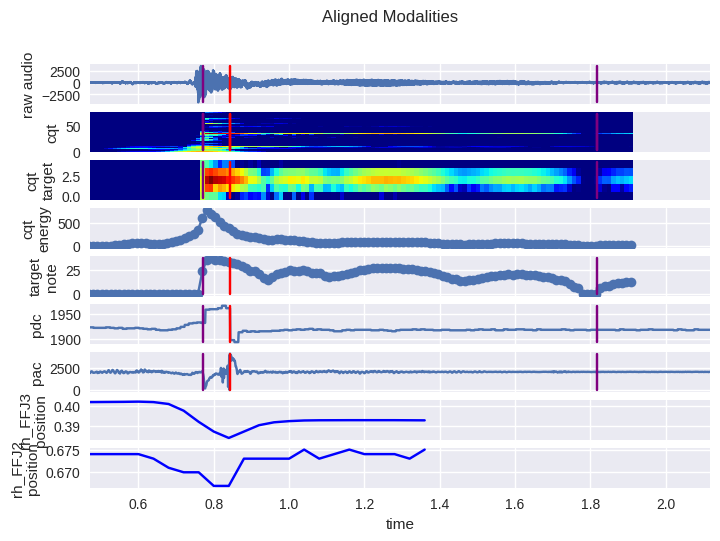

<Figure size 700x1500 with 0 Axes>

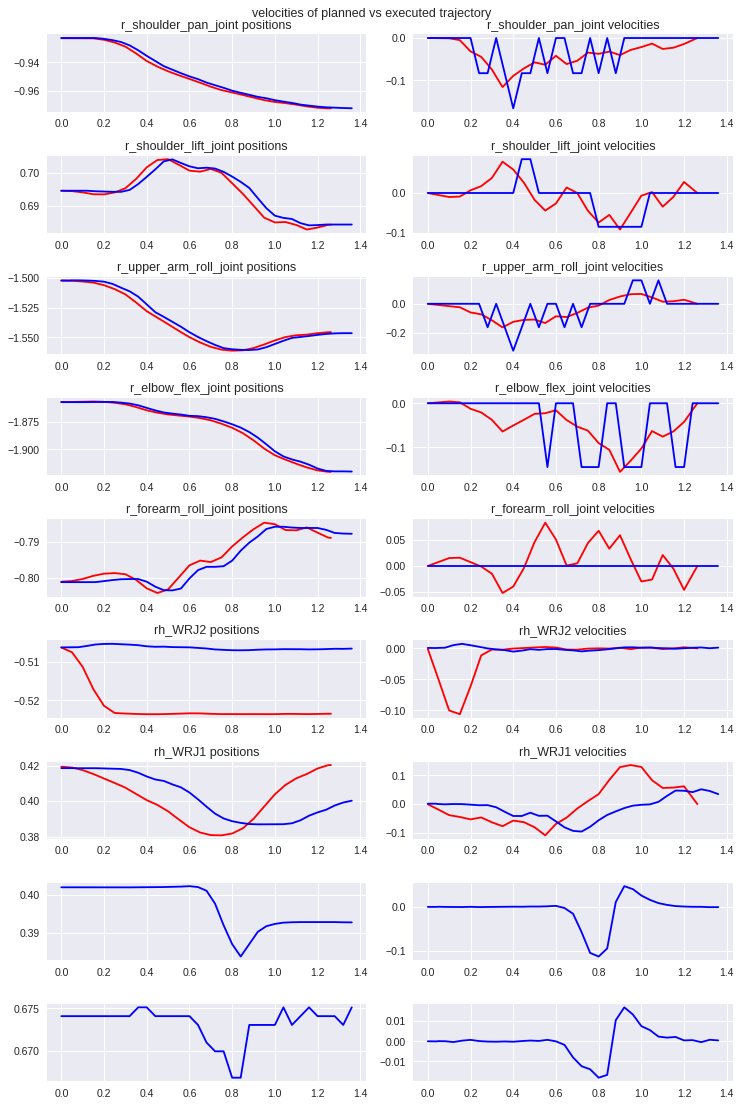

In [43]:
u.plot_episode(episodes_with_two_onsets[0])

In [38]:
u.play_audio(e)

In [44]:
e.detected_audio_onsets

[header: 
   seq: 70
   stamp: 
     secs: 1688398273
     nsecs: 349189226
   frame_id: ''
 note: "B4"
 confidence: 0.9720436334609985
 loudness: 43.18825149536133
 duration: 
   secs: 0
   nsecs:         0,
 header: 
   seq: 71
   stamp: 
     secs: 1688398274
     nsecs: 383991380
   frame_id: ''
 note: "B4"
 confidence: 0.9322203397750854
 loudness: 19.32097625732422
 duration: 
   secs: 0
   nsecs:         0]

In [34]:
[idx for idx, e in enumerate(episodes) if len(e.detected_tactile_plucks) > 8]

[]

In [35]:
multiple_tactile_plucks= [(i,e) for i,e in enumerate(episodes_with_one_onset) if len(e.detected_tactile_plucks) >= 2]
print(f"{len(multiple_tactile_plucks)} episodes with multiple detected plucks: {[i for i,_ in multiple_tactile_plucks]}")

66 episodes with multiple detected plucks: [0, 1, 2, 3, 4, 8, 12, 13, 15, 17, 19, 20, 33, 34, 40, 42, 44, 45, 46, 48, 49, 59, 61, 62, 65, 66, 67, 69, 73, 75, 79, 81, 82, 94, 97, 100, 103, 104, 108, 112, 115, 116, 117, 120, 123, 124, 127, 128, 135, 137, 138, 139, 141, 142, 148, 149, 151, 152, 153, 155, 156, 161, 167, 168, 174, 184]


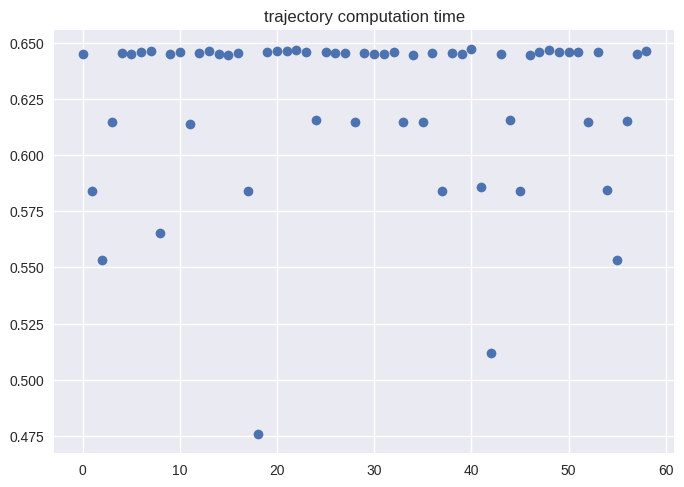

In [45]:
# plt.figure(figsize=(12,8))
plt.title('trajectory computation time')
plt.plot([(e.start_execution-e.header.stamp).to_sec() for e in episodes], 'o');

u.save_plot(f'processing time {bag_name}')

In [37]:
plt.suptitle('action parameters')
pairs = [(10,11), (12,13), (10,12), (11,13)]

for i, (a,b) in enumerate(pairs):
    plt.subplot(2,2,i+1)
    plt.title(f'{a} / {b}')
    plt.scatter([e.action_parameters.action_parameters[a] for e in episodes], [e.action_parameters.action_parameters[b] for e in episodes])
plt.tight_layout()

u.save_plot(f'parameter coverage {bag_name}')

In [38]:
cqt = u.cqt_from_episode(e)
print('        index:', ei)
print('    cqt start:', e.cqt.header.stamp.to_sec())
print('episode start:', e.header.stamp.to_sec())
print('        onset:', e.detected_audio_onsets[0].header.stamp.to_sec())
print('  episode end:', (e.header.stamp+e.length).to_sec())
print('      cqt end:', (e.cqt.header.stamp.to_sec() + e.cqt.hop_length*cqt.shape[0]/e.cqt.sample_rate))

print('   hop length:', e.cqt.hop_length/e.cqt.sample_rate)

onset_cqt_idx = int((e.detected_audio_onsets[-1].header.stamp-e.cqt.header.stamp).to_sec()/512 * 44100)
print('onset index: ', onset_cqt_idx)

        index: 5
    cqt start: 1685633652.765132
episode start: 1685633654.4267583
        onset: 1685633657.5885582
  episode end: 1685633658.1856456
      cqt end: 1685633658.82554
   hop length: 0.011609977324263039
onset index:  415


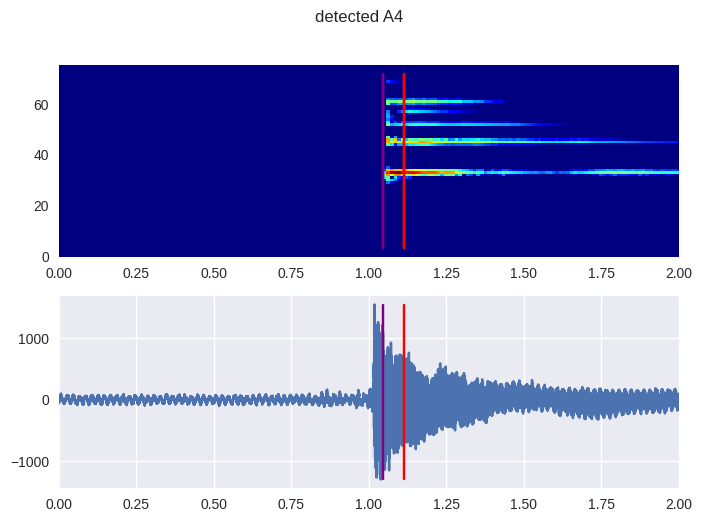

In [39]:
plt.subplot(2,1,1)
plt.suptitle(f"detected {e.detected_audio_onsets[0].note}");
u.plot_audio(e)
plt.subplot(2,1,2, sharex= plt.gca())
u.plot_raw_audio(e)
plt.xlim([0, 2]);

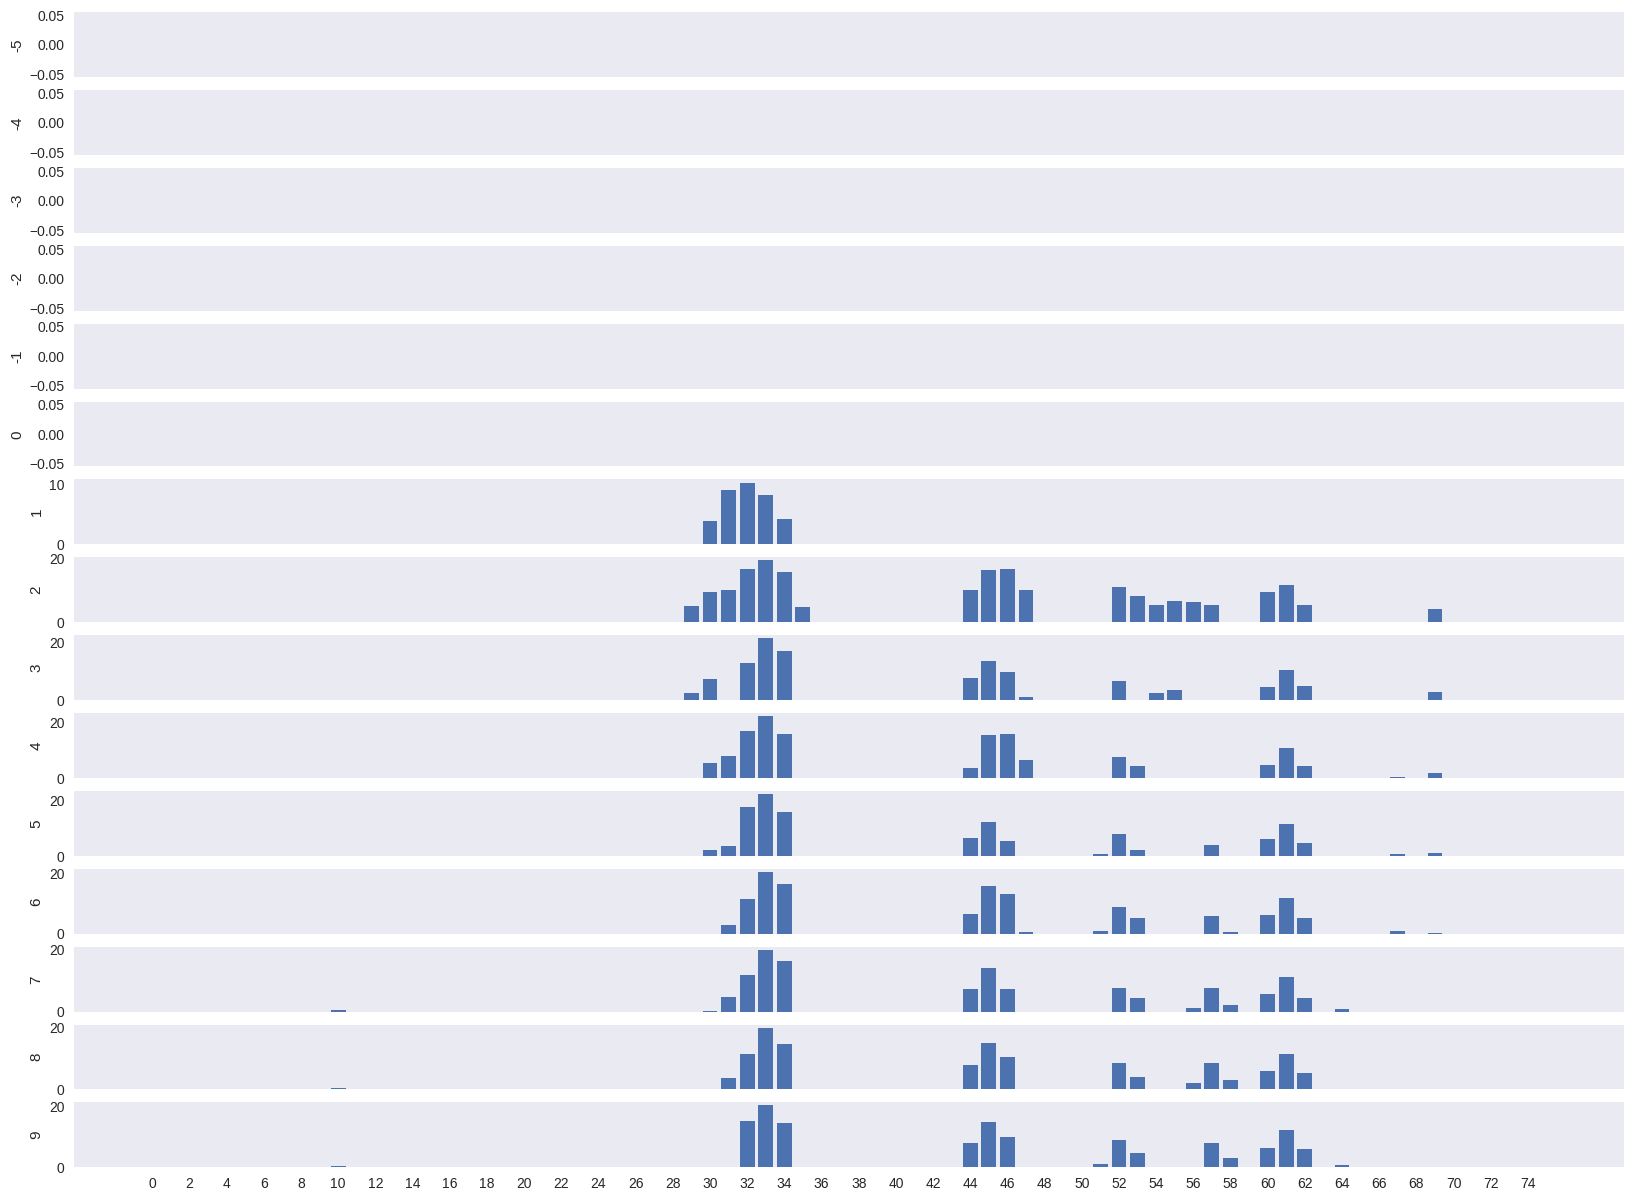

In [40]:
plt.figure(figsize=(20,15),dpi= 100)
for i in range(-5, 10):
    plt.subplot(15,1, i+6)
    plt.ylabel(f'{i}')
    plt.bar(np.arange(0, cqt.shape[1]), cqt[onset_cqt_idx+i,:])
    plt.xticks(np.arange(0, cqt.shape[1], 2))
    plt.grid(False)
    u.label_outer()

u.save_plot(f"onset dynamics for last onset in random episode {ei} {bag_name}")

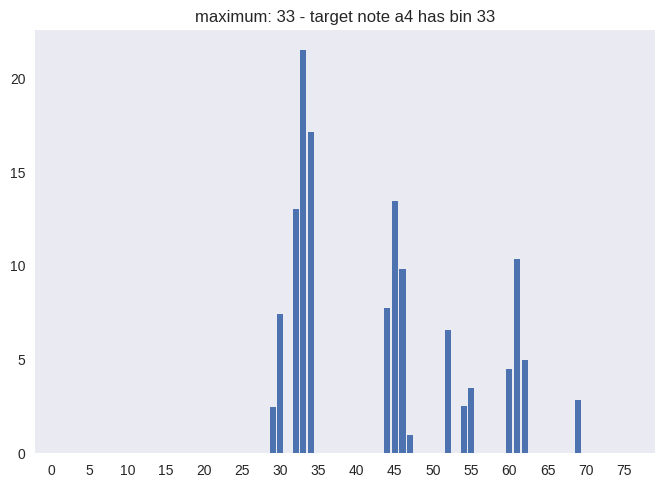

In [41]:
delta= 3
maximum= np.argmax(cqt[onset_cqt_idx+delta,2:])+2
plt.title(f"maximum: {maximum} - target note {note} has bin {note_bucket}")
plt.bar(range(2, e.cqt.number_of_semitones), cqt[onset_cqt_idx+delta,2:])
plt.xticks(np.arange(0, cqt.shape[1], 5))
plt.grid(False)

In [42]:
onset_cqt_idxs = [int((e.detected_audio_onsets[0].header.stamp-e.cqt.header.stamp).to_sec()/512*e.audio_info.sample_rate) for e in episodes_with_one_onset]

In [43]:
cqts= [u.cqt_from_episode(e) for e in episodes_with_one_onset]

In [44]:
onset_cqts= np.array([c[i,:] for c, i in zip(cqts, onset_cqt_idxs)])

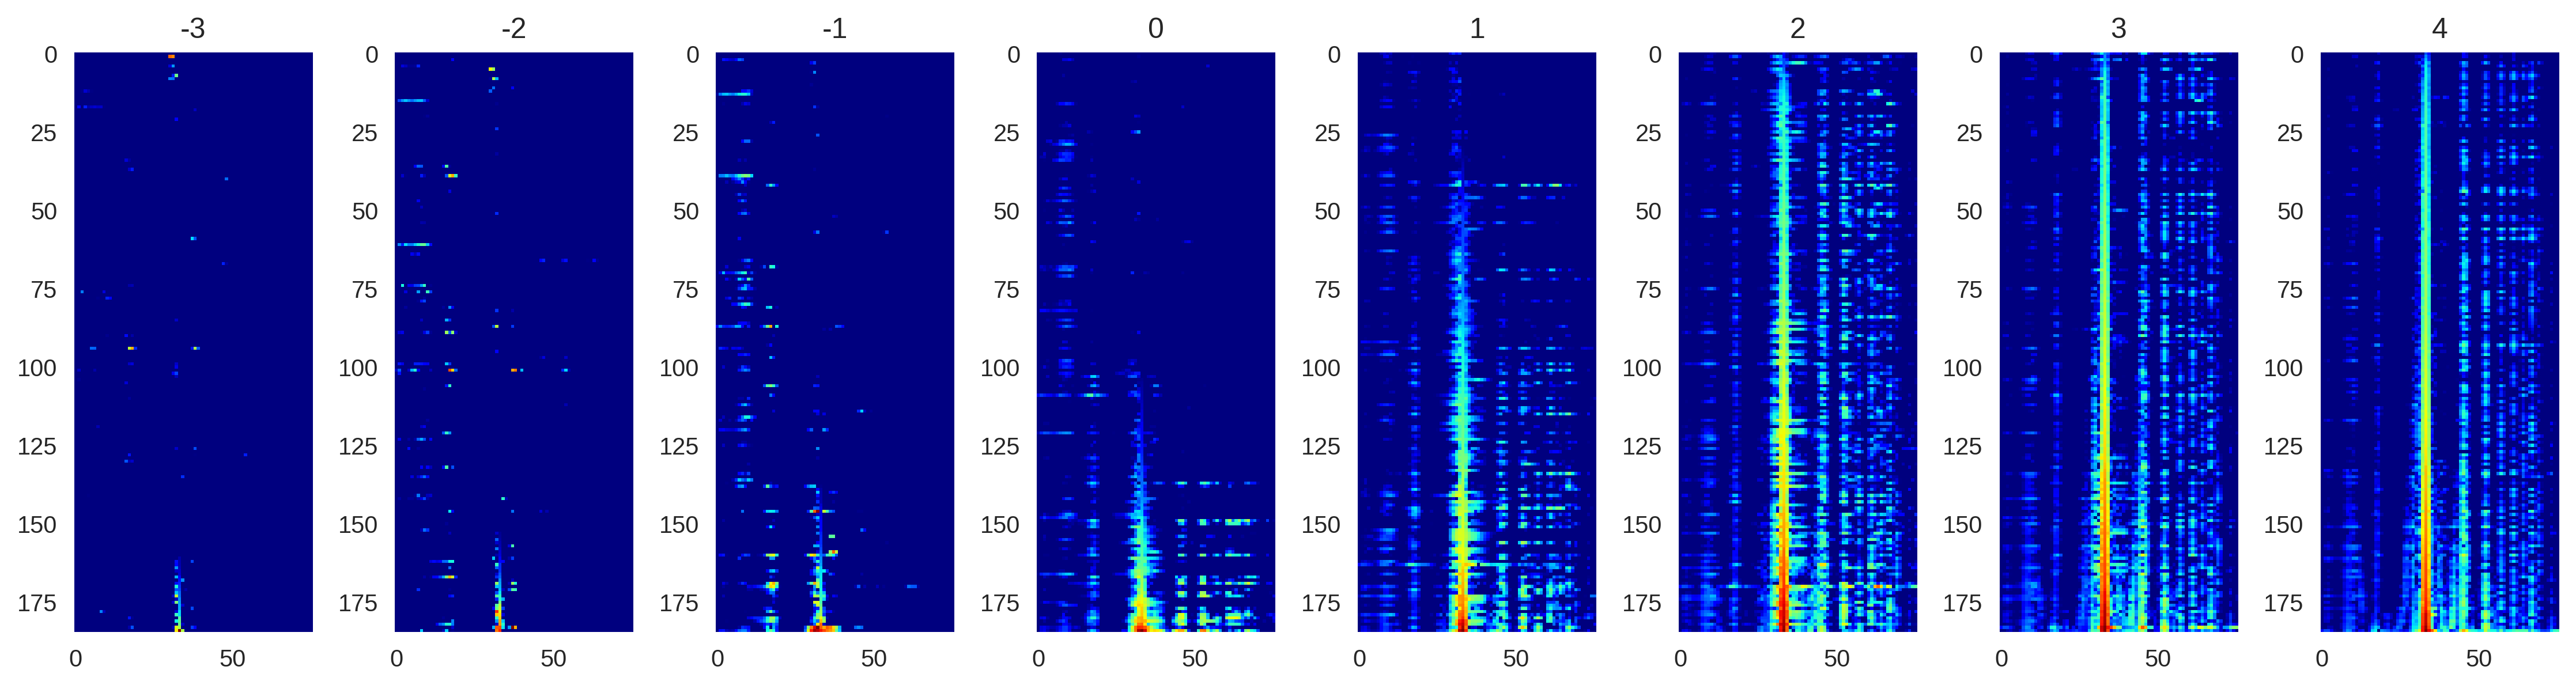

In [46]:
plt.figure(figsize=(15,8),dpi= 300)
shared_ax= None
offsets = list(range(-3, 5))
for idx,i in enumerate(offsets):
    shared_ax = plt.subplot(1,len(offsets), idx+1, sharey= shared_ax)
    plt.grid(False)
    plt.title(f'{i}')
    onset_cqts= np.array([c[oi+i,:] for c, oi in zip(cqts, onset_cqt_idxs)])
    plt.imshow(onset_cqts[onset_cqts[:,note_bucket].argsort()], cmap='jet')

plt.tight_layout()

u.save_plot(f"onset dynamics across episodes {bag_name}")

In [56]:
fig, ax = plt.subplots()
onset_cqts= np.array([c[oi+2,:] for c, oi in zip(cqts, onset_cqt_idxs)])
episode_order= onset_cqts[:,note_bucket].argsort()
im = plt.imshow(onset_cqts[episode_order].T, cmap='jet')
plt.grid(False)
plt.xlabel('episodes (sorted by loudness)')
plt.ylabel('cqt bins')

def animate(i):
    onset_cqts= np.array([c[oi+i,:] for c, oi in zip(cqts, onset_cqt_idxs)])
    im.set_data(onset_cqts[episode_order].T)
    ax.set_title(f"time around onset: {i*512/44100:.2F}")
    return lines
anim = FuncAnimation(fig, animate,
                     frames=range(-5,60),
                     interval=200)
video= anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()
u.save_anim(anim, f'cqts around onset {bag_name}')

In [57]:
fig, ax = plt.subplots()
onset_cqts= np.array([c[oi+2,:] for c, oi in zip(cqts, onset_cqt_idxs)])
episode_order= np.array([e.action_parameters.action_parameters[-1] for e in episodes_with_onset if e.detected_audio_onsets[0].loudness > 20]).argsort()
im = plt.imshow(onset_cqts[episode_order].T, cmap='jet')
plt.grid(False)
plt.xlabel('episodes (sorted along string)')
plt.ylabel('cqt bins')

def animate(i):
    onset_cqts= np.array([c[oi+i,:] for c, oi in zip(cqts, onset_cqt_idxs)])
    im.set_data(onset_cqts[episode_order].T)
    ax.set_title(f"time around onset: {i*512/44100:.2F}")
    return lines
anim = FuncAnimation(fig, animate,
                     frames=range(-5,60),
                     interval=200)
video= anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()
u.save_anim(anim, f'cqts around onset sorted along string {bag_name}')

/tmp/ipykernel_1163877/2179699219.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax= plt.subplot(1,20, subplotidx, sharey= ax)


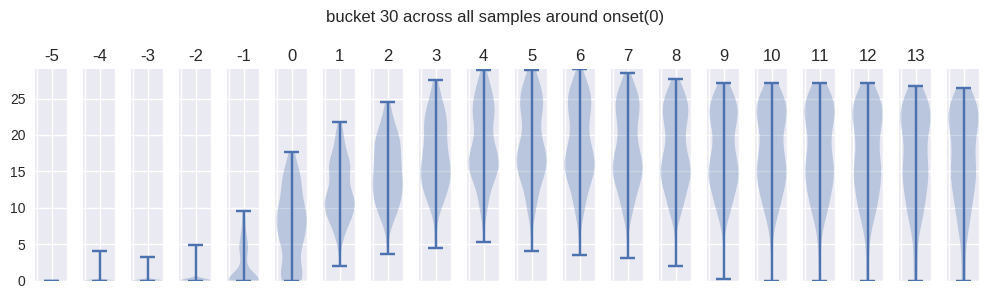

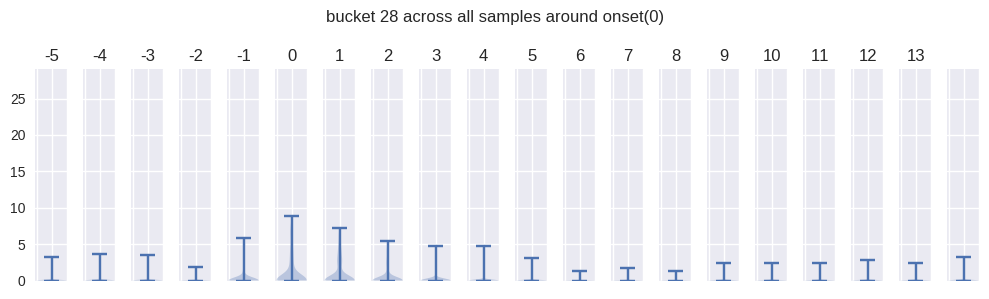

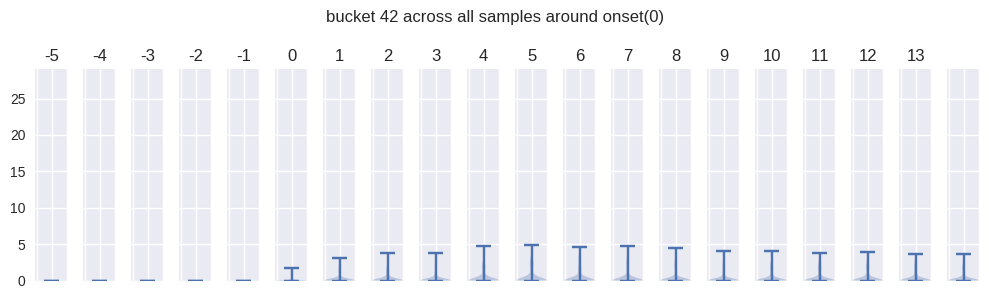

In [58]:
# E5 - 40

compare_buckets= [note_bucket, note_bucket-2, note_bucket+12]
maximum_power= max([c[oi-5:oi+14, compare_buckets].max() for c, oi in zip(cqts, onset_cqt_idxs)])
#print(maximum_power)
#maximum_power=20000

for bucket in compare_buckets:
    plt.figure(figsize=(10,3),dpi= 100)
    plt.tick_params('y', labelleft=True)
    ax= None
    plt.suptitle(f'bucket {bucket} across all samples around onset(0)')
    subplotidx= 1
    first= True
    for i in range(-5,15):
        onset_cqts= np.array([c[oi+i,:] for c, oi in zip(cqts, onset_cqt_idxs)])
        ax= plt.subplot(1,20, subplotidx, sharey= ax)
        if not first:
            ax.tick_params(labelleft=False)
        first= False
        ax.set_ylim(0, maximum_power)
        subplotidx+= 1
        if subplotidx <= 20:
            plt.title(f'{i}')
        plt.tick_params('x', labelbottom=False)
        plt.violinplot(onset_cqts[:,bucket])
        #plt.hist(onset_cqts[:,bucket], orientation= 'horizontal')
    plt.tight_layout()

In [59]:
note_after_transient = np.array([c[oi+delta,[note_bucket, note_bucket+12, note_bucket-5, note_bucket+12+7]].sum() for c, oi in zip(cqts, onset_cqt_idxs)])

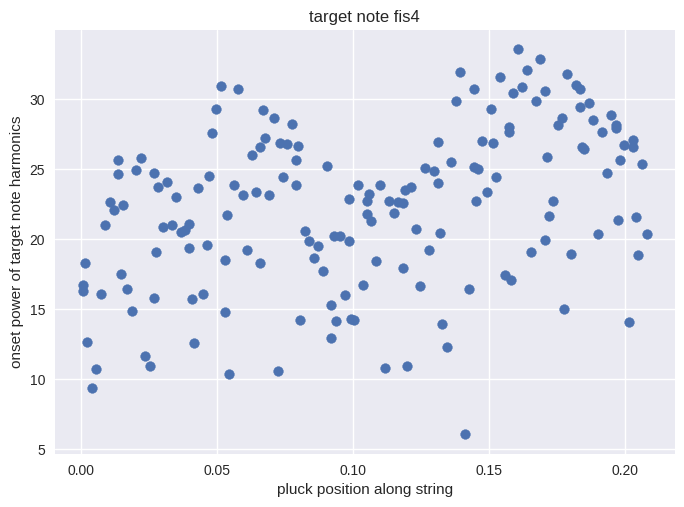

In [60]:
#big_plot()
plt.scatter([e.action_parameters.action_parameters[-1] for e in episodes_with_one_onset], note_after_transient)
plt.title(f'target note {note}');
plt.xlabel('pluck position along string');
plt.ylabel('onset power of target note harmonics');

u.save_plot(f'dynamics for string positions {bag_name}')

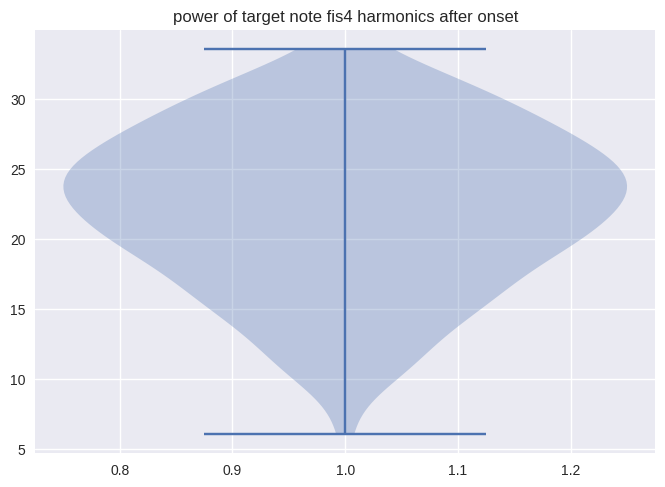

In [61]:
plt.title(f'power of target note {note} harmonics after onset')
plt.violinplot(note_after_transient);

u.save_plot(f'distribution of onset power {bag_name}')

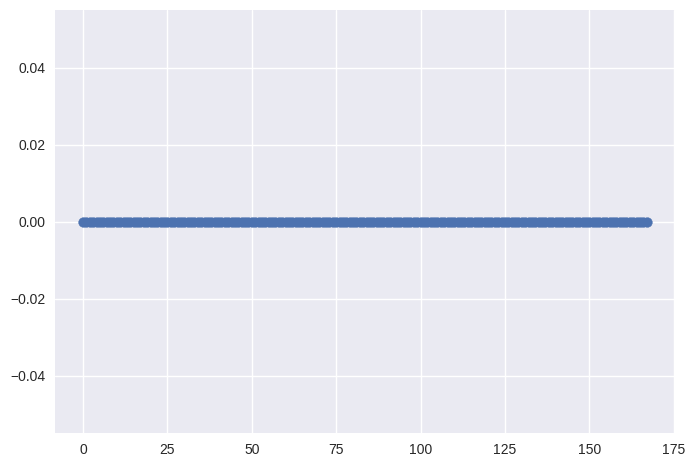

In [63]:
diff_note_and_neighbor = np.array([c[oi+delta,[note_bucket-4, note_bucket+4]].sum()/c[oi+delta,[note_bucket]].sum() for c, oi in zip(cqts, onset_cqt_idxs)])
# u.big_plot()
plt.scatter(*list(zip(*list(enumerate(diff_note_and_neighbor)))))
outliers= [(i,e) for (i,e) in enumerate(diff_note_and_neighbor) if e > diff_note_and_neighbor.mean() + 2.5*diff_note_and_neighbor.std()]
if len(outliers) > 0:
    plt.scatter(*list(zip(*outliers)), c='r')

for i, o in outliers:
    plt.text(i+0.05, o, str(i), fontsize=12)

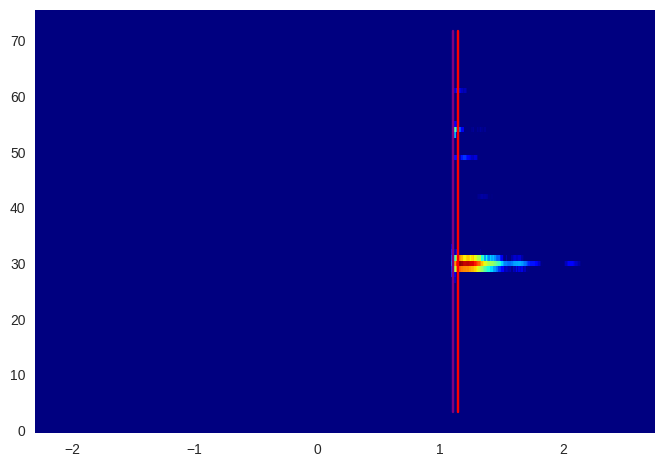

In [64]:
e= episodes_with_one_onset[17]
#cqt= cqts[17]
u.plot_cqt(e)

# X= np.tile(np.arange(cqt.shape[0])[:,np.newaxis], cqt.shape[1])
# Y= np.tile((np.arange(cqt.shape[1])*e.cqt.hop_length/e.cqt.sample_rate + (e.cqt.header.stamp - e.start_execution).to_sec())[:, np.newaxis], cqt.shape[0]).T
# plt.pcolormesh(Y, X, cqt, cmap='jet')


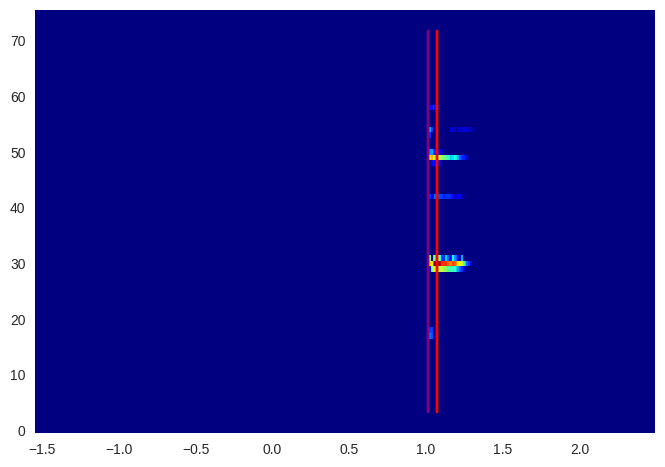

In [66]:
N=140
u.plot_audio(episodes_with_one_onset[N])
u.play_audio(episodes_with_one_onset[N])

In [67]:
idx = 0
N= 10

samples= list(reversed(sorted(enumerate(note_after_transient), key=lambda v: v[1])))[::int(len(episodes_with_one_onset)/N+1)]
print(f"{len(samples)} samples")

10 samples


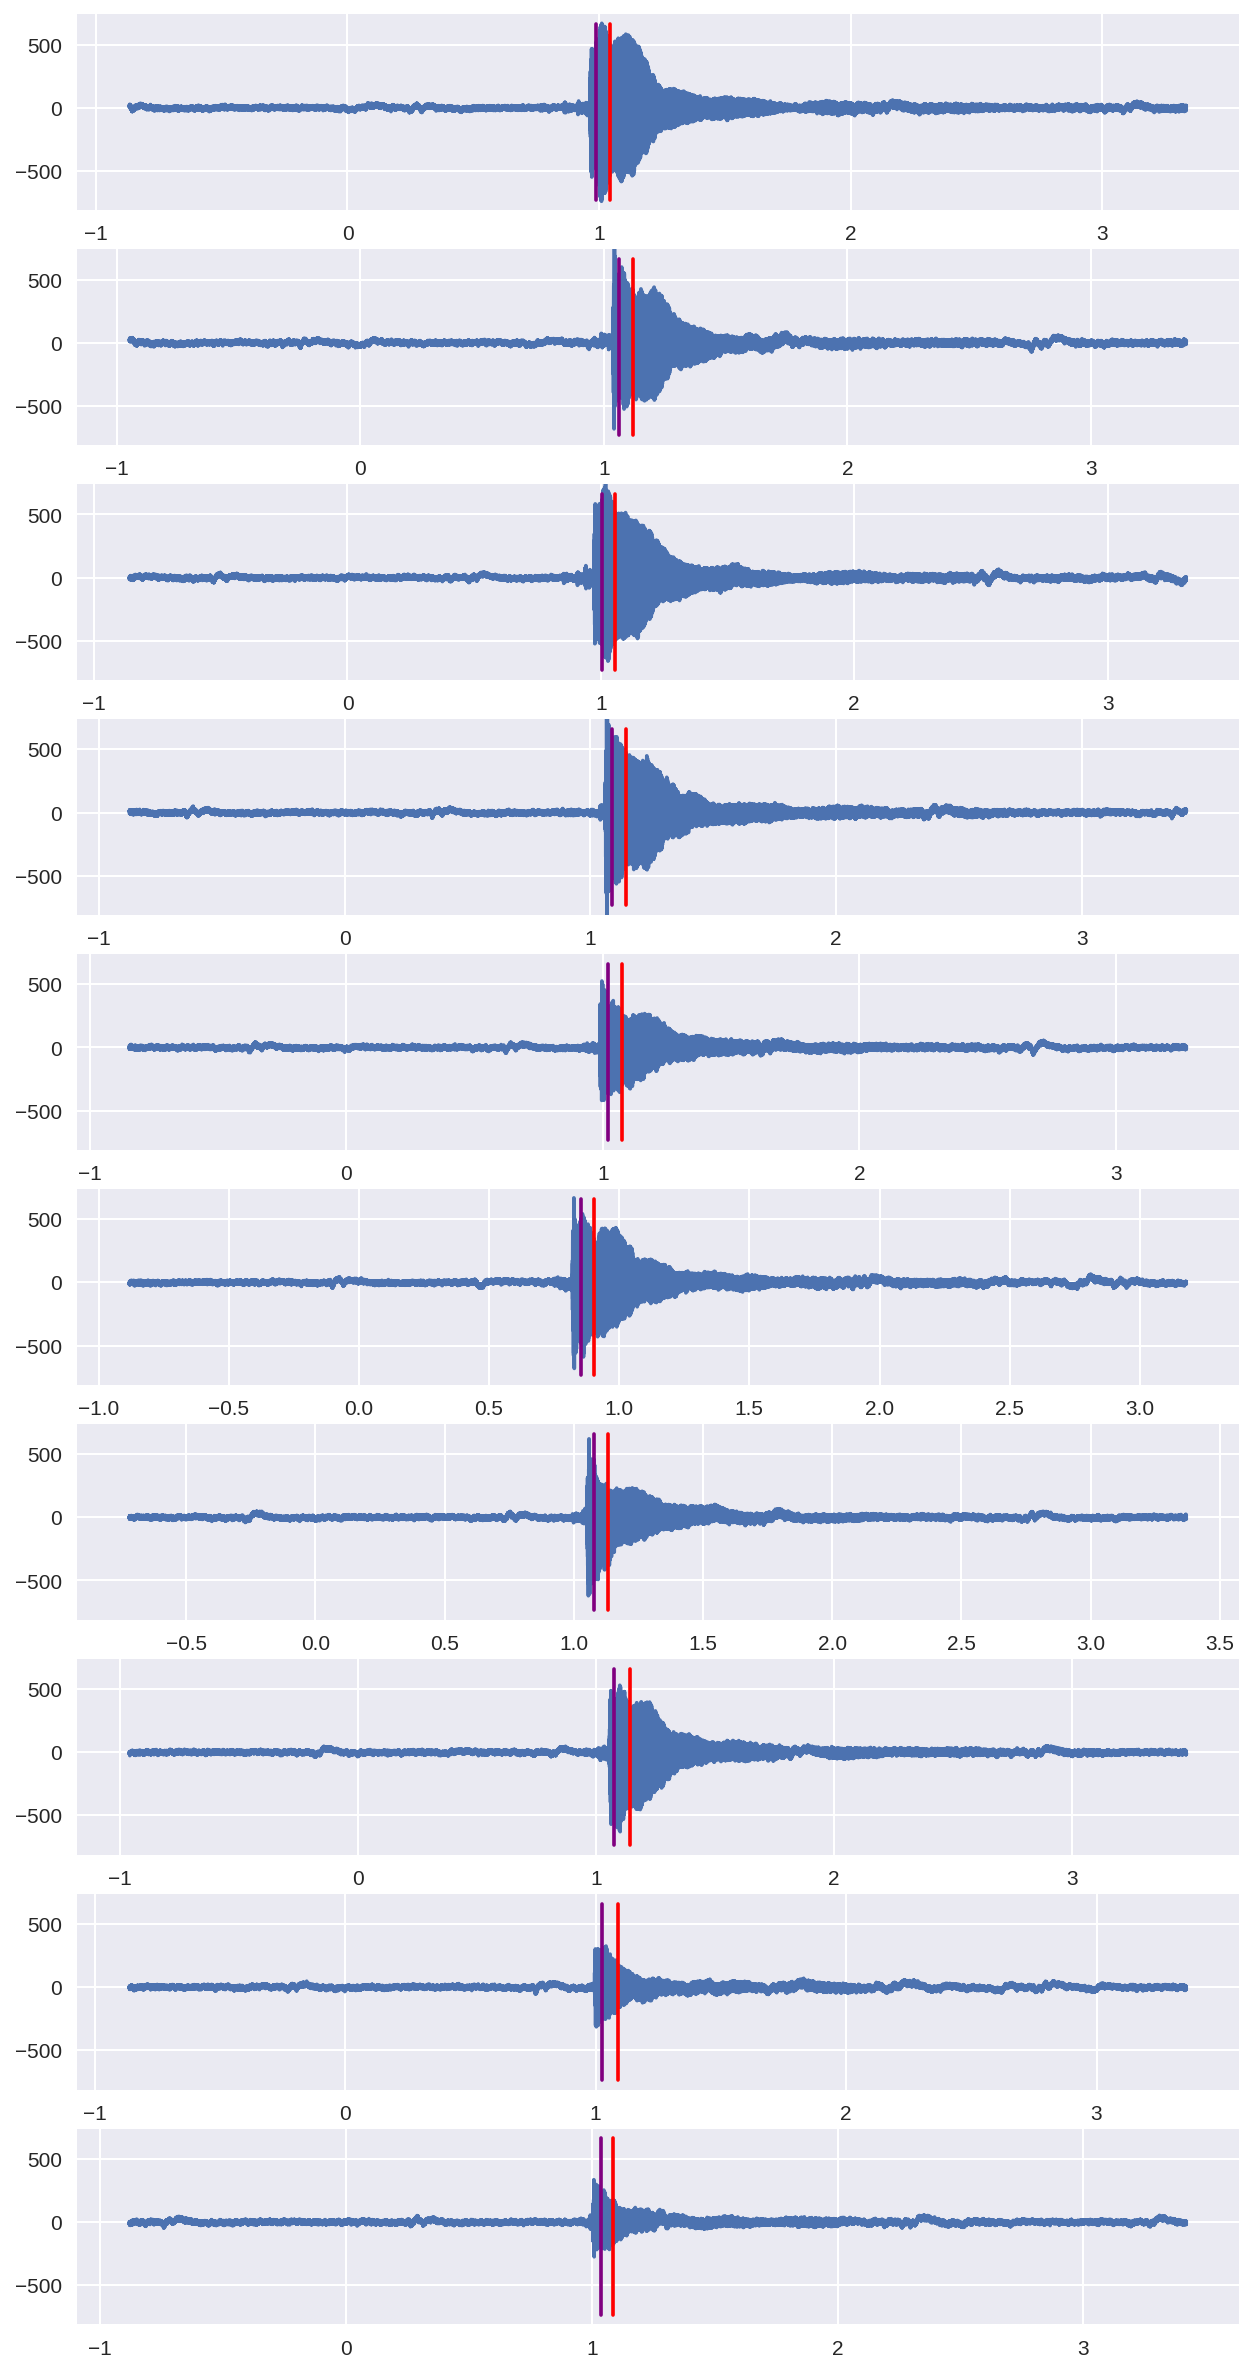

In [68]:
plt.figure(figsize=(10,20), dpi=150)
lim= None
for i, s in enumerate(samples):
    plt.subplot(len(samples), 1, i+1)
    u.plot_raw_audio(episodes_with_one_onset[s[0]])
    if lim is None:
        lim = plt.gca().get_ylim()
    else:
        plt.ylim(lim)

In [69]:
# Play samples

if True:
    idx=0
    for idx, (i, v) in enumerate(samples):
        e= episodes_with_one_onset[i]
        length = len(e.audio_data.audio.data)/2 / e.audio_info.sample_rate
        u.play_audio(e)
        print(f"{i} ({idx} / {len(samples)}); length: {length:2}; volume: {v:.2F}; dB: {e.detected_audio_onsets[0].loudness:.2F}")
        rospy.sleep(rospy.Duration(length))

63 (0 / 10); length: 4.2; volume: 33.55; dB: 28.91
27 (1 / 10); length: 4.34; volume: 29.46; dB: 24.68
35 (2 / 10); length: 4.17; volume: 27.11; dB: 27.95
83 (3 / 10); length: 4.3; volume: 25.65; dB: 25.82
62 (4 / 10); length: 4.12; volume: 23.89; dB: 17.85
113 (5 / 10); length: 4.06; volume: 22.71; dB: 23.25
60 (6 / 10); length: 4.09; volume: 20.85; dB: 16.71
73 (7 / 10); length: 4.44; volume: 19.20; dB: 25.16
41 (8 / 10); length: 4.22; volume: 16.67; dB: 16.83
115 (9 / 10); length: 4.3; volume: 14.11; dB: 14.11


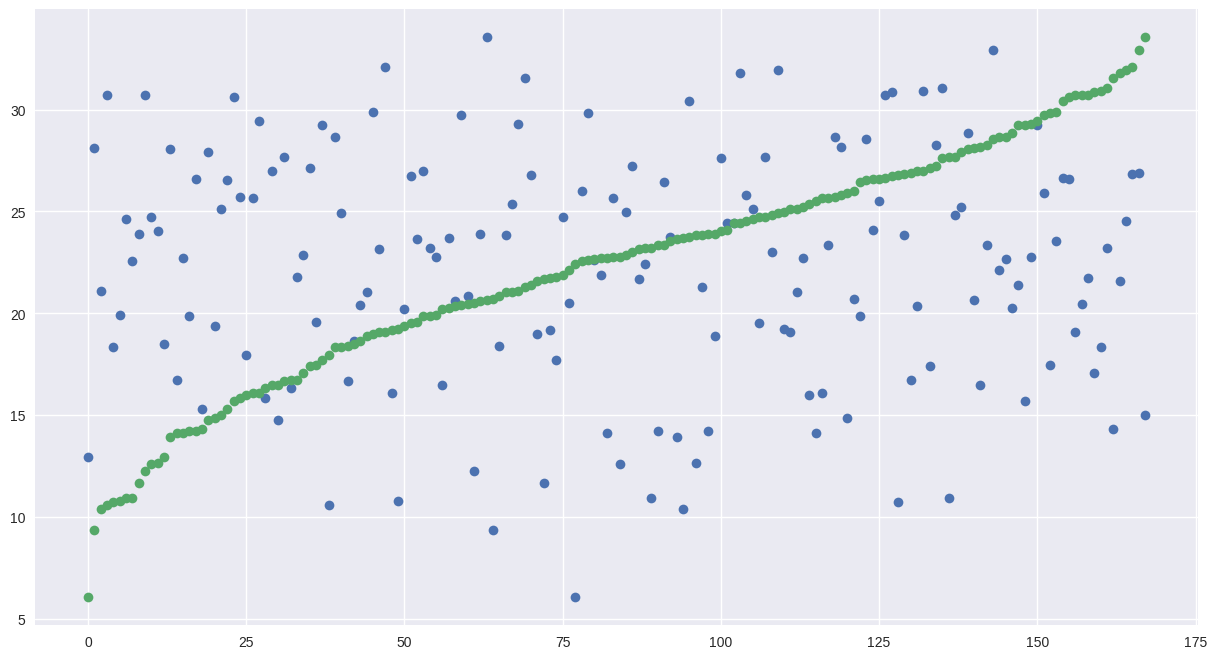

In [70]:
u.big_plot()
note_after_transient_normalized= note_after_transient/np.max(note_after_transient)
plt.plot(note_after_transient, 'o')
plt.plot(sorted(note_after_transient), 'o');

plt.plot([i for i,o in outliers], note_after_transient[[i for i,_ in outliers]], 'o', color='red')

u.save_plot(f"volume distribution {bag_name}")

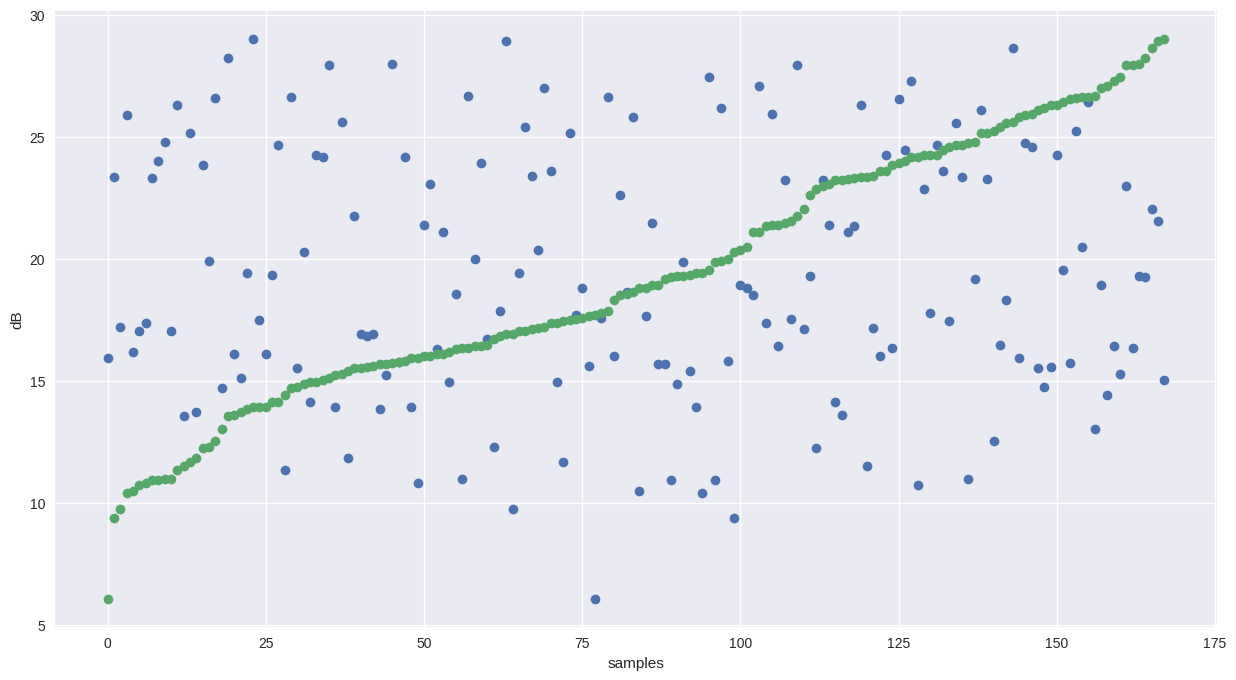

In [72]:
u.big_plot()
loudness = np.array([e.detected_audio_onsets[0].loudness for e in episodes_with_onset])
plt.plot(loudness, 'o')
plt.plot(sorted(loudness), 'o')
plt.xlabel('samples')
plt.ylabel('dB')
u.save_plot(f"volume distribution dB {bag_name}")

In [73]:
for i in (note_after_transient > 80000).nonzero()[0]:
    plt.figure()
    plt.title(f"{i}")
    plot_audio(episodes_with_one_onset[i])
    
# for i in (note_after_transient > 50000).nonzero()[0]:
#     play_audio(episodes_with_one_onset[i])


In [74]:
loudness = np.array([e.detected_audio_onsets[0].loudness for e in episodes_with_one_onset])

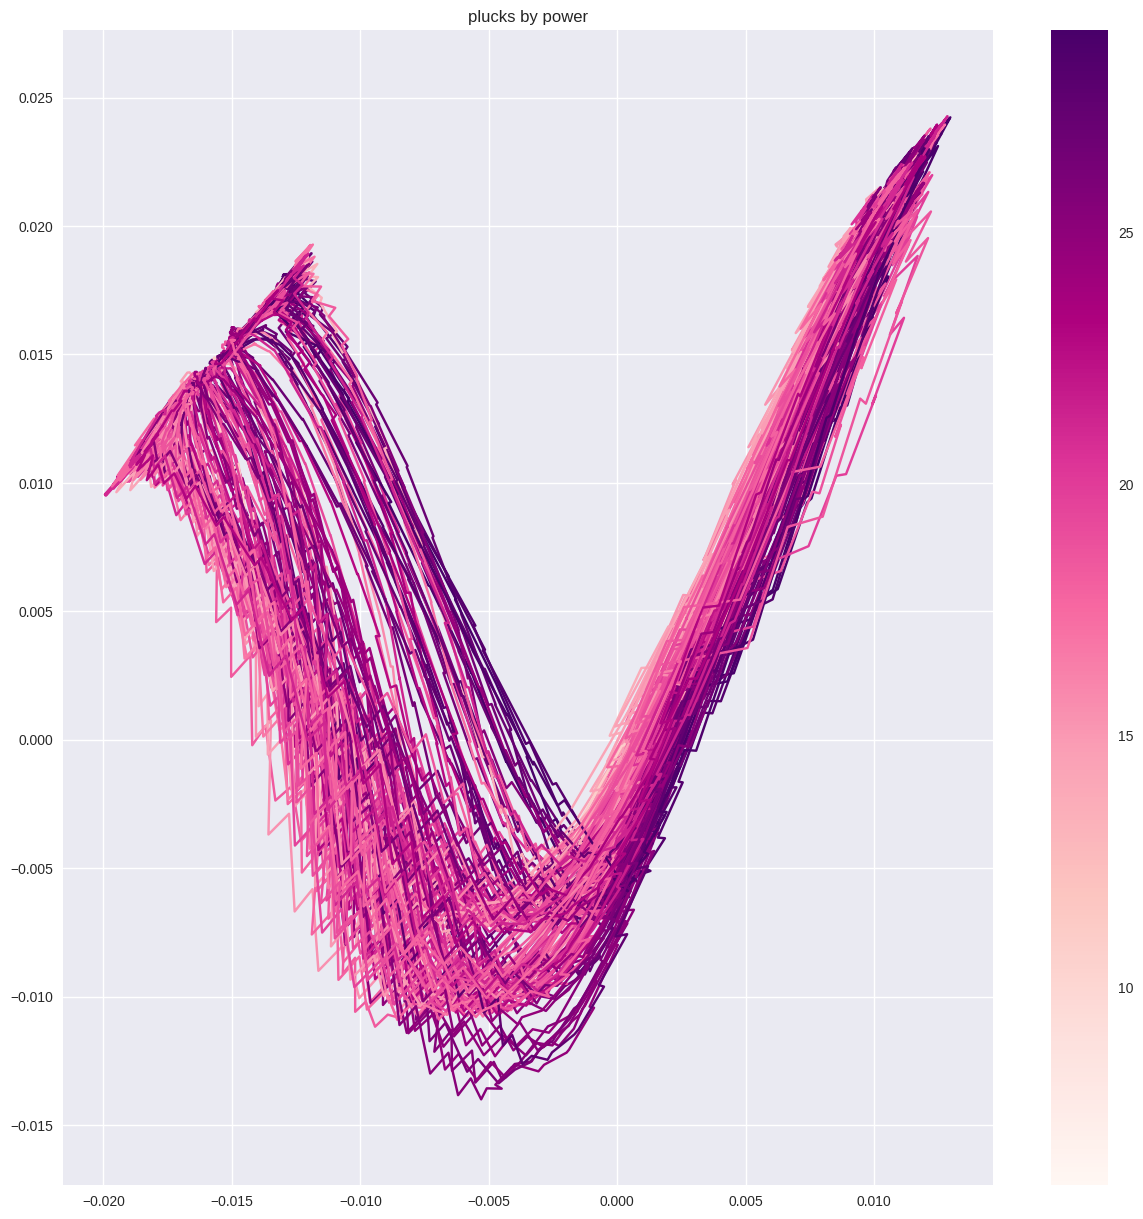

In [78]:
plt.figure(figsize=(15,15), dpi=100)

for i, e in enumerate([e for e in episodes_with_no_onset if e.action_parameters.action_parameters[12]>0]):
    plt.plot([-p.pose.position.y for p in e.executed_path.poses], [p.pose.position.z for p in e.executed_path.poses], color='lightblue')


cmap=plt.get_cmap('RdPu')
for i, e in enumerate([e for e in episodes_with_one_onset if e.action_parameters.action_parameters[12]<0]):
    # plt.plot([-p.pose.position.y for p in e.executed_path.poses], [p.pose.position.z for p in e.executed_path.poses], color= plt.get_cmap('RdPu')(note_after_transient_normalized[i]))
    plt.plot(
        [-p.pose.position.y for p in e.executed_path.poses],
        [p.pose.position.z for p in e.executed_path.poses],
        color= cmap(loudness[i]/np.max(loudness)))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(loudness), vmax=np.max(loudness)))
plt.colorbar(sm, ax= plt.gca())
#plt.gca().set_aspect('equal', 'box')
plt.gca().axis('equal')
plt.title('plucks by power')
#plt.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=plt.get_cmap('gist_rainbow')))
u.save_plot(f'plucks by power {note} {bag_name}')

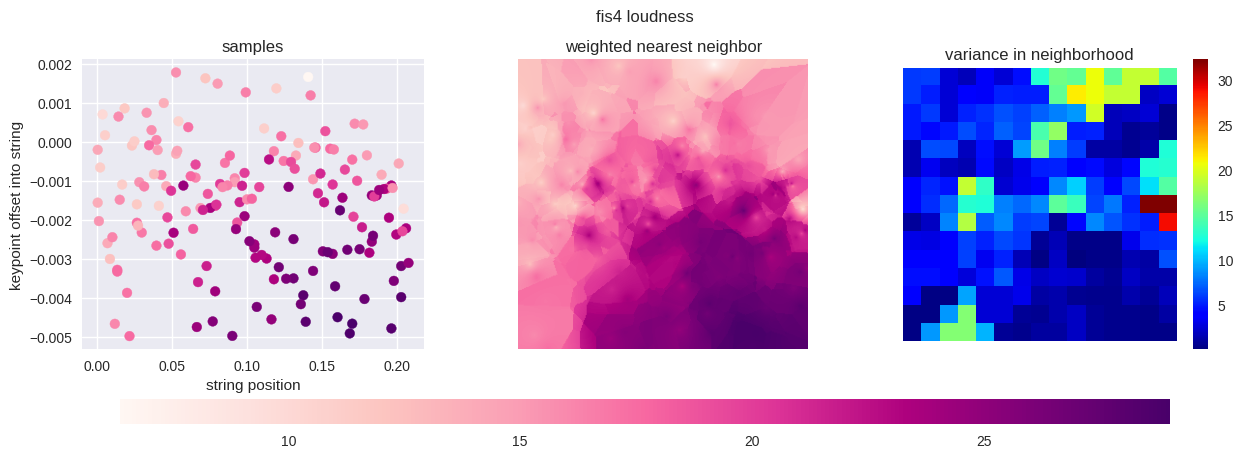

In [79]:
def normalize(a):
    return (a-np.min(a))/(np.max(a)-np.min(a))

# string position
x = np.array([e.action_parameters.action_parameters[-1] for e in episodes_with_one_onset])
# keypoint_pos_y
y = np.array([e.action_parameters.action_parameters[10] for e in episodes_with_onset])

# loudness
c = np.array([e.detected_audio_onsets[0].loudness for e in episodes_with_onset])

from scipy.spatial import cKDTree

grid_size = 300
# output grid
zi = np.zeros((grid_size, grid_size))
# coordinates
xi, yi = np.meshgrid(
    np.linspace(0, 1, grid_size),
    np.linspace(0, 1, grid_size)
    )
grid_points = np.column_stack((xi.ravel(), yi.ravel()))
tree = cKDTree(np.column_stack((normalize(x), normalize(y))))
distances, indices = tree.query(grid_points, k=3)
for i in range(grid_size):
    for j in range(grid_size):
        weights = 1.0 / distances[i * grid_size + j]  # Inverse of distances as weights
        weights /= np.sum(weights)  # Normalize weights
        zi[i, j] = np.dot(c[indices[i * grid_size + j]], weights)

grid_size = 15
# output grid
vari = np.zeros((grid_size, grid_size))
# coordinates
xi, yi = np.meshgrid(
    np.linspace(0, 1, grid_size),
    np.linspace(0, 1, grid_size)
    )
grid_points = np.column_stack((xi.ravel(), yi.ravel()))
tree = cKDTree(np.column_stack((normalize(x), normalize(y))))
distances, indices = tree.query(grid_points, k=5)
for i in range(grid_size):
    for j in range(grid_size):
        neighborhood = c[indices[i * grid_size + j]]
        vari[i,j] = np.var(neighborhood)

cmap=plt.get_cmap('RdPu')
# cmap=plt.get_cmap('brg')

fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.suptitle(f'{note} loudness')
#Q.plot(x='string_position', y='keypoint_pos_y', kind='scatter', c='loudness', colormap='brg', ax=ax[0], colorbar=False)
ax[0].scatter(x,y, c=c, cmap=cmap)
ax[0].set_title('samples')
ax[0].set_xlabel('string position')
ax[0].set_ylabel('keypoint offset into string')

im = ax[1].imshow(zi, cmap=cmap, origin='lower')
ax[1].axis('off')
ax[1].set_title('weighted nearest neighbor')

imvar = ax[2].imshow(vari, cmap='jet', origin='lower')
ax[2].axis('off')
ax[2].set_title('variance in neighborhood')
fig.colorbar(imvar, ax=ax[2])

fig.subplots_adjust(bottom=0.3)
cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.05])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal');
u.save_plot(f'string kp_ypos {note} {bag_name}')

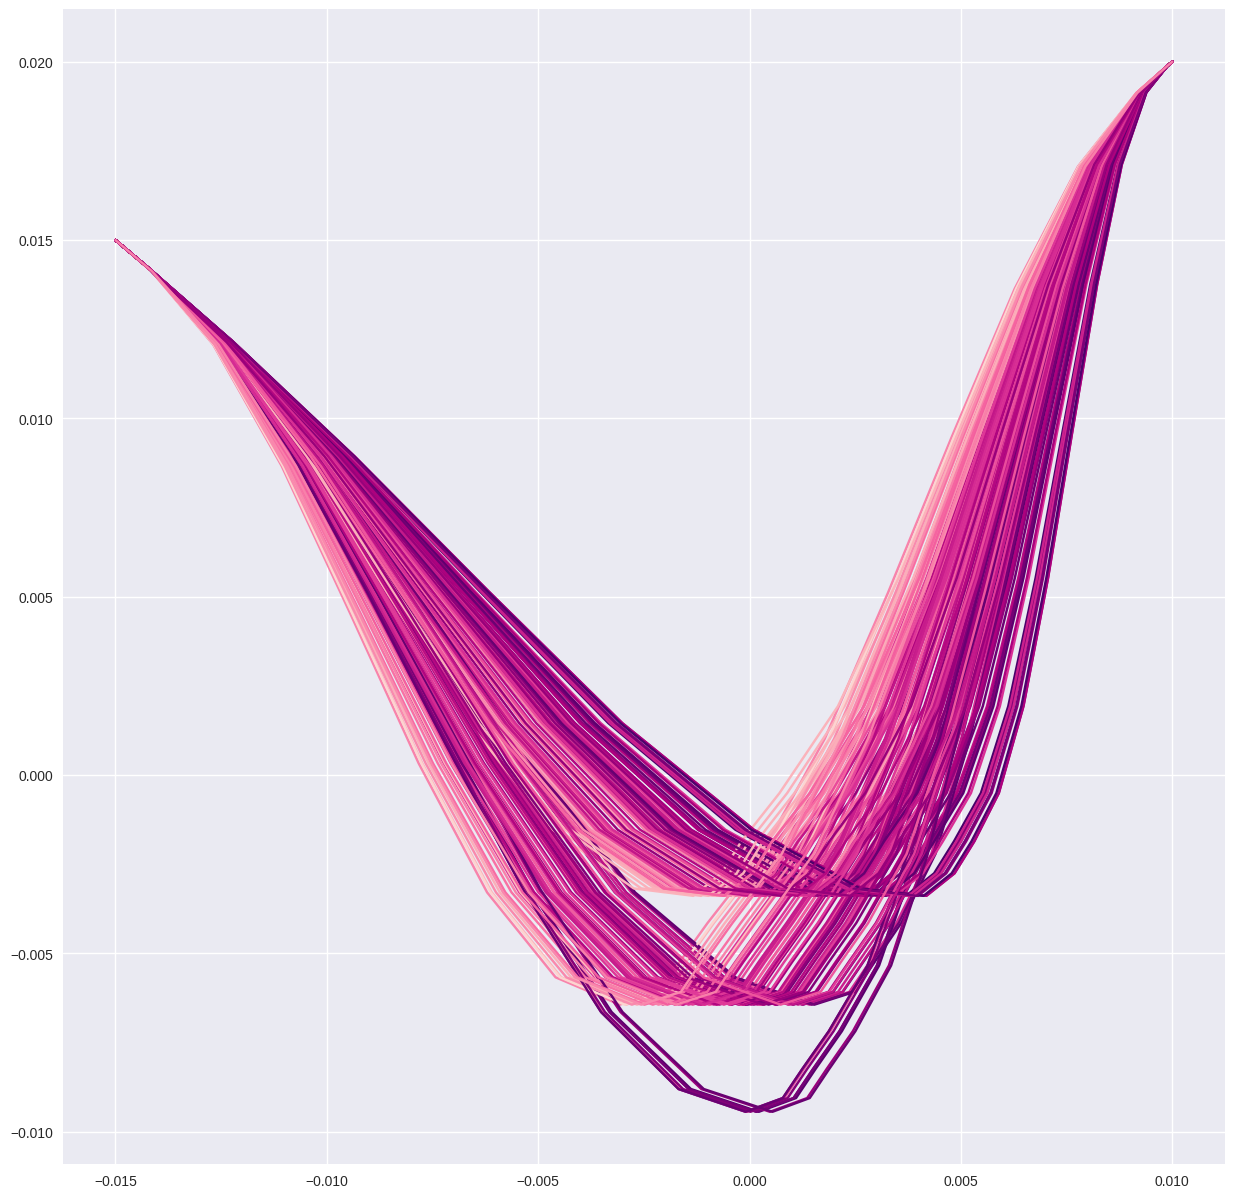

In [80]:
plt.figure(figsize=(15,15), dpi=100)
for i,e in enumerate([e for e in episodes_with_one_onset if e.action_parameters.action_parameters[12] < 0]):
    plt.plot([-p.pose.position.y for p in e.commanded_path.poses], [p.pose.position.z for p in e.commanded_path.poses], color= plt.get_cmap('RdPu')(note_after_transient_normalized[i]))

#plt.suptitle('plucks by power')
u.save_plot(f'cmd plucks by power {note} {bag_name}')
#loud_episodes = [e for i, e in enumerate(episodes_with_one_onset) if note_after_transient[i] > 10000]
#for e in loud_episodes:
#    plt.plot([p.pose.position.y for p in e.commanded_path.poses], [p.pose.position.z for p in e.commanded_path.poses], 'r')

In [151]:
parameters = np.hstack([np.array([e.action_parameters.action_parameters for e in episodes_with_one_onset]), note_after_transient[:, np.newaxis]])
parameters_no_onset = np.array([e.action_parameters.action_parameters for e in episodes_with_no_onset])

In [152]:
N=4
string_segment_length = string_length / N
string_segments= np.arange(0, string_length, string_length/N)+ string_segment_length/2

NameError: name 'string_length' is not defined

In [153]:
ax= None

margin= string_segment_length/2

def check_params_right(p):
    return (np.abs(p[:, 14] - d) < margin) & (p[:,12] < 0)
def check_params_left(p):
    return (np.abs(p[:, 14] - d) < margin) & (p[:,12] > 0)

normalize = mpl.colors.Normalize(vmin= 0.0, vmax= max(parameters[:,15]))

directions=["forward", "back"]
for direction, check_params in zip(directions, [check_params_right, check_params_left]):
    u.big_plot()
    for i, d in enumerate(string_segments):
        ax= plt.subplot(1,4, i+1, sharex= ax, sharey= ax);
        ax.set_box_aspect(1)

        p = parameters_no_onset[check_params(parameters_no_onset)]
        plt.quiver(-p[:, 10], p[:, 11], -p[:, 12], p[:, 13], scale=.4, angles='xy', color='lightblue');

        p = parameters[check_params(parameters)]
        plt.title(f'd = {d:.3f}');
        q= plt.quiver(-p[:, 10], p[:, 11], -p[:, 12], p[:, 13], p[:, 15], scale=.4, angles='xy', cmap=plt.get_cmap('RdPu'), norm= normalize);

    plt.subplots_adjust(bottom=0.12)
    cbar_ax = plt.gcf().add_axes([0.125, 0.25, 0.775, 0.05])
    plt.colorbar(q, cax=cbar_ax, orientation='horizontal');
    u.save_plot(f'volume for waypoints along string {note} {direction} {bag_name}')

NameError: name 'string_segment_length' is not defined

<Figure size 800x550 with 0 Axes>

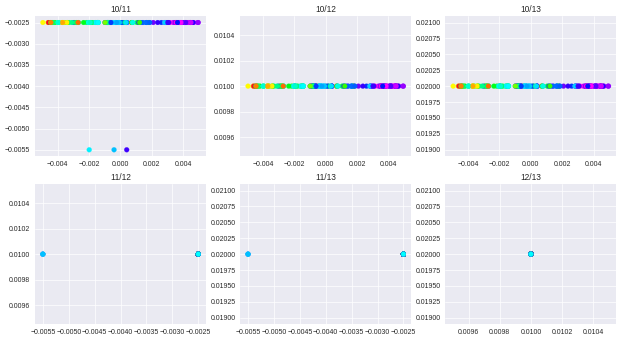

In [154]:
from itertools import combinations

plt.suptitle('pairwise volume plots of action parameters');
plt.figure(figsize=(15,8), dpi=50)
sidx= 1
for i,j in combinations([10,11,12,13], 2):
    plt.subplot(2,3,sidx)
    plt.title(f'{i}/{j}')
    sidx+= 1
    plt.scatter([e.action_parameters.action_parameters[i] for e in episodes_with_one_onset], [e.action_parameters.action_parameters[j] for e in episodes_with_one_onset], cmap=plt.get_cmap('gist_rainbow'), c=note_after_transient_normalized)
    #plt.scatter([e.action_parameters.action_parameters[i] for e in episodes_with_no_onset], [e.action_parameters.action_parameters[j] for e in episodes_with_no_onset], color='r')

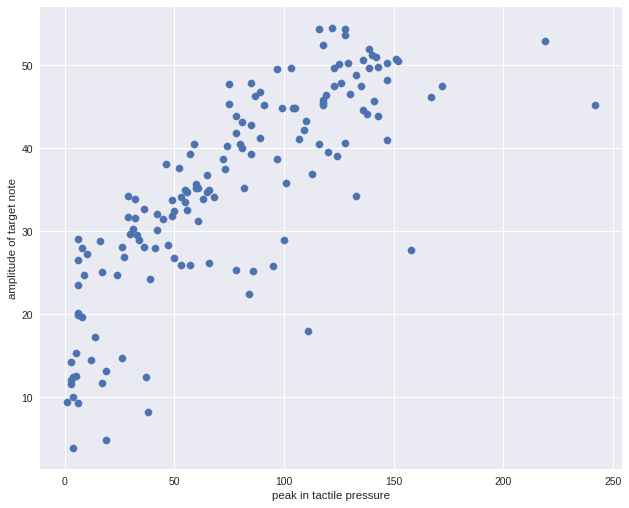

In [155]:
max_pdc_peak = [np.max([t.tactile.pdc for t in e.tactile_data])-e.tactile_data[0].tactile.pdc for e in episodes_with_one_onset]

plt.figure(figsize=(10,8), dpi=75)
plt.scatter(
    max_pdc_peak,
    note_after_transient,
    # would need to be normalized
    #c= plt.get_cmap('jet')([e.action_parameters.action_parameters[0] for e in episodes_with_one_onset])
    )

#plt.plot(np.arange(0,400), model.predict(np.arange(0,400).reshape(-1,1)))
plt.xlabel('peak in tactile pressure')
plt.ylabel('amplitude of target note')
#plt.xlim(0, 800)
u.save_plot(f'amplitude vs tactile {note} {bag_name}')

In [ ]:
#from sklearn.linear_model import RANSACRegressor
#
#model = RANSACRegressor(residual_threshold=100, max_trials=1000).fit(np.array(max_pdc_peak).reshape(-1,1),np.array(note_after_transient))


In [ ]:
######
######
# Neural Network Playground
######
######

In [156]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

ModuleNotFoundError: No module named 'torch'

In [ ]:
parameter_tensor = F.normalize(torch.FloatTensor([e.action_parameters.action_parameters for e in episodes_with_one_onset]), dim=1)
volume_tensor = F.normalize(torch.FloatTensor([[n] for n in note_after_transient]), dim=0)

In [ ]:
ds= [(parameter_tensor[i,:], volume_tensor[i]) for i in range(len(note_after_transient))]

In [ ]:
dl = torch.utils.data.DataLoader(ds, shuffle= True)

In [ ]:
# regress volume
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(15, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = F.softmax(self.fc1(x))
        #x = F.relu(self.fc2(x))
        return x

net = Net()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(1,500):
    for i, data in enumerate(dl):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    if epoch % 50 == 0:
        print(f'{epoch}')

In [ ]:
pred = net(torch.FloatTensor([e.action_parameters.action_parameters for e in episodes_with_one_onset])).detach().numpy();
pred.shape

plt.figure(figsize=(10,20), dpi=100)
plt.title('action parameters')
sidx= 1
combs = list(combinations([10,11,12,13], 2))
for i,j in combs:
    plt.subplot(len(combs),2,sidx)
    sidx+=1
    plt.title(f'{i}/{j} ground truth')
    plt.scatter([e.action_parameters.action_parameters[i] for e in episodes_with_one_onset], [e.action_parameters.action_parameters[j] for e in episodes_with_one_onset], cmap=plt.get_cmap('gist_rainbow'), c=note_after_transient_normalized)
    plt.subplot(len(combs),2,sidx)
    plt.title(f'{i}/{j} predicted')
    sidx+= 1
    plt.scatter([e.action_parameters.action_parameters[i] for e in episodes_with_one_onset], [e.action_parameters.action_parameters[j] for e in episodes_with_one_onset], cmap=plt.get_cmap('gist_rainbow'), c=pred)

In [ ]:
e= episodes_with_one_onset[1]
#plt.figure(dpi=100)
N=5
ax = plt.subplot(N,1,1)
plot_raw_audio(e)
ax = plt.subplot(N,1,2, sharex=ax)
plot_audio(e)
ax = plt.subplot(N,1,3, sharex=ax)
plot_tactile(e)
ax = plt.subplot(N,1,4, sharex=ax)
plot_tactile_ac(e)
ax = plt.subplot(N,1,5, sharex=ax)
#plot_joint(e, "rh_FFJ2")
#plot_joint(e, "rh_FFJ3")
for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()

In [ ]:
signal = np.array(struct.unpack('{0}h'.format(int(len(e.audio_data.audio.data)/2)), e.audio_data.audio.data), dtype=float)
plt.plot(np.arange(len(signal), dtype=float)/e.audio_info.sample_rate+e.audio_data.header.stamp.to_sec() - e.start_execution.to_sec(), signal)